In [42]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from LSPIN_model import Model
from utils import DataSet

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [5]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [6]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [7]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [8]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [9]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [11]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [12]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [13]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [14]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [15]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [16]:
from collections import Counter
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [17]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [19]:
dataset = DataSet(**{'_data':X_train, '_labels':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,
                '_test_data':X_test, '_test_labels':y_test})

In [33]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

### LLSPIN

In [26]:
def llspin_objective(trial):  
    global model
            
    params = {
        "feature_selection" : True,
        "sigma" : 0.5,
        "display_step" : 500,
        "hidden_layers_node" : [100,100,10,1], # hidden layers: 100,100,10,1
        "input_node" : X_train.shape[1],
        "output_node" : 1
    }
    params['stddev_input'] = 0.1 
    params['activation']= 'none'
    params['batch_size']= X_train.shape[0]
    params['feature_selection_dimension']=[10]
    params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    num_epoch = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    model_dir =None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [35]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2021-05-31 21:39:34,816] A new study created in memory with name: no-name-859f30ba-983b-4382-8396-7f447c1fdf7c


num_samples : 10
Epoch: 500 train loss=0.010604906 valid loss= 0.012560671
train reg_fs: 0.004470093175768852
Epoch: 1000 train loss=0.016968865 valid loss= 0.012062725
train reg_fs: 0.004493233747780323
Epoch: 1500 train loss=0.016278829 valid loss= 0.012230149
train reg_fs: 0.004516263958066702
Epoch: 2000 train loss=0.014613844 valid loss= 0.011937684
train reg_fs: 0.004535425454378128
Epoch: 2500 train loss=0.011341271 valid loss= 0.011685958
train reg_fs: 0.00454847514629364
Epoch: 3000 train loss=0.010449624 valid loss= 0.011181092
train reg_fs: 0.004558568354696035
Epoch: 3500 train loss=0.011822904 valid loss= 0.011361351
train reg_fs: 0.0045653763227164745
Epoch: 4000 train loss=0.023249488 valid loss= 0.010991002
train reg_fs: 0.004569294396787882
Epoch: 4500 train loss=0.008979671 valid loss= 0.011048516
train reg_fs: 0.004567359574139118
Epoch: 5000 train loss=0.012232030 valid loss= 0.011131961
train reg_fs: 0.004564294125884771
Epoch: 5500 train loss=0.014747333 valid los

[I 2021-05-31 21:41:20,663] Trial 0 finished with value: 0.005115962552702996 and parameters: {'lam': 0.005323416986151032, 'learning_rate': 0.01138761745815921, 'num_epoch': 15000}. Best is trial 0 with value: 0.005115962552702996.


Epoch: 15000 train loss=0.010713438 valid loss= 0.009420076
train reg_fs: 0.004108712542802095
Optimization Finished!
test loss: 0.010031543672084808, test acc: 1.0
In trial:---------------------
validation mse: 0.005115962552702996
num_samples : 10
Epoch: 500 train loss=0.018155865 valid loss= 0.014273824
train reg_fs: 0.00776185467839241
Epoch: 1000 train loss=0.016353332 valid loss= 0.014033789
train reg_fs: 0.007765653543174267
Epoch: 1500 train loss=0.013019951 valid loss= 0.013559317
train reg_fs: 0.007548531051725149
Epoch: 2000 train loss=0.011703068 valid loss= 0.012801116
train reg_fs: 0.007189603988081217
Epoch: 2500 train loss=0.011976153 valid loss= 0.010906220
train reg_fs: 0.006922388914972544
Epoch: 3000 train loss=0.008321772 valid loss= 0.009792577
train reg_fs: 0.006675615441054106
Epoch: 3500 train loss=0.009346087 valid loss= 0.009632761
train reg_fs: 0.006409266497939825
Epoch: 4000 train loss=0.008578040 valid loss= 0.009042656
train reg_fs: 0.006172845605760813


[I 2021-05-31 21:41:56,647] Trial 1 finished with value: 0.003019079955294617 and parameters: {'lam': 0.008838318896272393, 'learning_rate': 0.11067111578047624, 'num_epoch': 5000}. Best is trial 1 with value: 0.003019079955294617.


Epoch: 5000 train loss=0.006254537 valid loss= 0.008896273
train reg_fs: 0.005847209133207798
Optimization Finished!
test loss: 0.008765710517764091, test acc: 1.0
In trial:---------------------
validation mse: 0.003019079955294617
num_samples : 10
Epoch: 500 train loss=0.007908462 valid loss= 0.011115920
train reg_fs: 0.0039762030355632305
Epoch: 1000 train loss=0.015585454 valid loss= 0.011109073
train reg_fs: 0.004041066858917475
Epoch: 1500 train loss=0.024678685 valid loss= 0.010398252
train reg_fs: 0.004032365046441555
Epoch: 2000 train loss=0.007921781 valid loss= 0.010089977
train reg_fs: 0.003962767776101828
Epoch: 2500 train loss=0.007474450 valid loss= 0.010338854
train reg_fs: 0.00387880252674222
Epoch: 3000 train loss=0.008026700 valid loss= 0.009329170
train reg_fs: 0.0038118669763207436
Epoch: 3500 train loss=0.008212084 valid loss= 0.009537412
train reg_fs: 0.0037518786266446114
Epoch: 4000 train loss=0.007461965 valid loss= 0.008064155
train reg_fs: 0.00369159691035747

[I 2021-05-31 21:42:32,389] Trial 2 finished with value: 0.0030372610000587016 and parameters: {'lam': 0.004590845476623955, 'learning_rate': 0.06221322205455364, 'num_epoch': 5000}. Best is trial 1 with value: 0.003019079955294617.


Epoch: 5000 train loss=0.005825178 valid loss= 0.006604650
train reg_fs: 0.0035186591558158398
Optimization Finished!
test loss: 0.006585412193089724, test acc: 1.0
In trial:---------------------
validation mse: 0.0030372610000587016
num_samples : 10
Epoch: 500 train loss=0.013246339 valid loss= 0.014997731
train reg_fs: 0.00767709081992507
Epoch: 1000 train loss=0.016483245 valid loss= 0.014929708
train reg_fs: 0.007737363688647747
Epoch: 1500 train loss=0.016076062 valid loss= 0.014230362
train reg_fs: 0.007780604530125856
Epoch: 2000 train loss=0.020995511 valid loss= 0.014068134
train reg_fs: 0.007801208179444075
Epoch: 2500 train loss=0.012662087 valid loss= 0.013505485
train reg_fs: 0.00781348068267107
Epoch: 3000 train loss=0.013655605 valid loss= 0.014065767
train reg_fs: 0.007813764736056328
Epoch: 3500 train loss=0.021372436 valid loss= 0.012845239
train reg_fs: 0.007799674291163683
Epoch: 4000 train loss=0.017675901 valid loss= 0.012756735
train reg_fs: 0.00777121027931571
E

[I 2021-05-31 21:44:16,125] Trial 3 finished with value: 0.0019017118404111128 and parameters: {'lam': 0.009048652507790512, 'learning_rate': 0.017676565138301067, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019017118404111128.


Epoch: 15000 train loss=0.008317216 valid loss= 0.007992525
train reg_fs: 0.005938077345490456
Optimization Finished!
test loss: 0.007793887984007597, test acc: 1.0
In trial:---------------------
validation mse: 0.0019017118404111128
num_samples : 10
Epoch: 500 train loss=0.006053469 valid loss= 0.008584560
train reg_fs: 0.0010579917579889297
Epoch: 1000 train loss=0.007167195 valid loss= 0.008354554
train reg_fs: 0.0010698032565414906
Epoch: 1500 train loss=0.009784027 valid loss= 0.008019943
train reg_fs: 0.0010806042701005936
Epoch: 2000 train loss=0.008746091 valid loss= 0.007951256
train reg_fs: 0.0010893183061853051
Epoch: 2500 train loss=0.011327194 valid loss= 0.007921319
train reg_fs: 0.0010971337324008346
Epoch: 3000 train loss=0.016086556 valid loss= 0.008210663
train reg_fs: 0.0011034406488761306
Epoch: 3500 train loss=0.012690787 valid loss= 0.007667857
train reg_fs: 0.0011084334691986442
Epoch: 4000 train loss=0.014563445 valid loss= 0.007671359
train reg_fs: 0.0011125296

[I 2021-05-31 21:44:51,759] Trial 4 finished with value: 0.005873840246320358 and parameters: {'lam': 0.0012424478144719786, 'learning_rate': 0.015898020941265672, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019017118404111128.


Epoch: 5000 train loss=0.010291450 valid loss= 0.006991634
train reg_fs: 0.0011186113115400076
Optimization Finished!
test loss: 0.007961997762322426, test acc: 1.0
In trial:---------------------
validation mse: 0.005873840246320358
num_samples : 10
Epoch: 500 train loss=0.012808256 valid loss= 0.012130239
train reg_fs: 0.004470249637961388
Epoch: 1000 train loss=0.017403610 valid loss= 0.011556278
train reg_fs: 0.004503381438553333
Epoch: 1500 train loss=0.014214478 valid loss= 0.011700343
train reg_fs: 0.0044517675414681435
Epoch: 2000 train loss=0.007428058 valid loss= 0.011633372
train reg_fs: 0.004345263354480267
Epoch: 2500 train loss=0.008593620 valid loss= 0.010231103
train reg_fs: 0.004238656722009182
Epoch: 3000 train loss=0.007470663 valid loss= 0.009470955
train reg_fs: 0.004156217444688082
Epoch: 3500 train loss=0.007947216 valid loss= 0.008746475
train reg_fs: 0.0040665799751877785
Epoch: 4000 train loss=0.012581028 valid loss= 0.008206903
train reg_fs: 0.0039844270795583

[I 2021-05-31 21:45:27,612] Trial 5 finished with value: 0.0024353820384216437 and parameters: {'lam': 0.005188282004928067, 'learning_rate': 0.05852162659358529, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019017118404111128.


Epoch: 5000 train loss=0.004519451 valid loss= 0.006269275
train reg_fs: 0.0037609790451824665
Optimization Finished!
test loss: 0.006008547730743885, test acc: 1.0
In trial:---------------------
validation mse: 0.0024353820384216437
num_samples : 10
Epoch: 500 train loss=0.013927144 valid loss= 0.012484577
train reg_fs: 0.006489187479019165
Epoch: 1000 train loss=0.015483825 valid loss= 0.012010472
train reg_fs: 0.006475784350186586
Epoch: 1500 train loss=0.013664007 valid loss= 0.012356635
train reg_fs: 0.006357127334922552
Epoch: 2000 train loss=0.012445919 valid loss= 0.011067425
train reg_fs: 0.0061928643845021725
Epoch: 2500 train loss=0.017507620 valid loss= 0.010629327
train reg_fs: 0.006021219305694103
Epoch: 3000 train loss=0.010376937 valid loss= 0.009708840
train reg_fs: 0.005832854192703962
Epoch: 3500 train loss=0.010733659 valid loss= 0.008796691
train reg_fs: 0.0056528677232563496
Epoch: 4000 train loss=0.012215565 valid loss= 0.008819889
train reg_fs: 0.005490338429808

[I 2021-05-31 21:46:38,197] Trial 6 finished with value: 0.004424789589115596 and parameters: {'lam': 0.007575999242864385, 'learning_rate': 0.04443790337393647, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019017118404111128.


Epoch: 10000 train loss=0.007227057 valid loss= 0.009255614
train reg_fs: 0.004641002509742975
Optimization Finished!
test loss: 0.009201804175972939, test acc: 1.0
In trial:---------------------
validation mse: 0.004424789589115596
num_samples : 10
Epoch: 500 train loss=0.006314690 valid loss= 0.007569465
train reg_fs: 0.0016327991615980864
Epoch: 1000 train loss=0.007074292 valid loss= 0.007595936
train reg_fs: 0.0016166908899322152
Epoch: 1500 train loss=0.003416260 valid loss= 0.005592307
train reg_fs: 0.0015691707376390696
Epoch: 2000 train loss=0.008486298 valid loss= 0.004379160
train reg_fs: 0.001532553811557591
Epoch: 2500 train loss=0.003923073 valid loss= 0.003880493
train reg_fs: 0.001499312580563128
Epoch: 3000 train loss=0.015835300 valid loss= 0.003686528
train reg_fs: 0.0014788125408813357
Epoch: 3500 train loss=0.003351239 valid loss= 0.003410424
train reg_fs: 0.0014649491058662534
Epoch: 4000 train loss=0.002701009 valid loss= 0.003872581
train reg_fs: 0.0014514536596

[I 2021-05-31 21:48:22,124] Trial 7 finished with value: 0.0018829556721344726 and parameters: {'lam': 0.0018652524283607871, 'learning_rate': 0.0763074115188201, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.004261161 valid loss= 0.003203854
train reg_fs: 0.001362091163173318
Optimization Finished!
test loss: 0.0031277420930564404, test acc: 1.0
In trial:---------------------
validation mse: 0.0018829556721344726
num_samples : 10
Epoch: 500 train loss=0.007469012 valid loss= 0.007199566
train reg_fs: 0.0015194524312391877
Epoch: 1000 train loss=0.006116259 valid loss= 0.004277573
train reg_fs: 0.0014001908712089062
Epoch: 1500 train loss=0.005437258 valid loss= 0.004600210
train reg_fs: 0.0013372799148783088
Epoch: 2000 train loss=0.003392893 valid loss= 0.004421894
train reg_fs: 0.0012841788120567799
Epoch: 2500 train loss=0.001600963 valid loss= 0.003665796
train reg_fs: 0.001247712061740458
Epoch: 3000 train loss=0.001680941 valid loss= 0.003930656
train reg_fs: 0.0012236410984769464
Epoch: 3500 train loss=0.004405914 valid loss= 0.003371227
train reg_fs: 0.0012057487620040774
Epoch: 4000 train loss=0.003075398 valid loss= 0.003373644
train reg_fs: 0.0011910187

[I 2021-05-31 21:50:06,502] Trial 8 finished with value: 0.0022503081080902736 and parameters: {'lam': 0.0018294431773937165, 'learning_rate': 0.1714676542835499, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.001884319 valid loss= 0.003327637
train reg_fs: 0.0011053701164200902
Optimization Finished!
test loss: 0.0031184556428343058, test acc: 1.0
In trial:---------------------
validation mse: 0.0022503081080902736
num_samples : 10
Epoch: 500 train loss=0.011844147 valid loss= 0.007128962
train reg_fs: 0.0013515406753867865
Epoch: 1000 train loss=0.009877238 valid loss= 0.004124677
train reg_fs: 0.0012803948484361172
Epoch: 1500 train loss=0.009606186 valid loss= 0.003608161
train reg_fs: 0.0012334717903286219
Epoch: 2000 train loss=0.003427966 valid loss= 0.003711369
train reg_fs: 0.001217404380440712
Epoch: 2500 train loss=0.002511499 valid loss= 0.003736027
train reg_fs: 0.001196706434711814
Epoch: 3000 train loss=0.004082676 valid loss= 0.004103831
train reg_fs: 0.0011756193125620484
Epoch: 3500 train loss=0.007404013 valid loss= 0.003709466
train reg_fs: 0.0011608756612986326
Epoch: 4000 train loss=0.002107989 valid loss= 0.003770847
train reg_fs: 0.0011509004

[I 2021-05-31 21:51:49,480] Trial 9 finished with value: 0.001935560847120119 and parameters: {'lam': 0.001570821458809122, 'learning_rate': 0.13604818291021806, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.001703734 valid loss= 0.002986984
train reg_fs: 0.0011042158585041761
Optimization Finished!
test loss: 0.0029370603151619434, test acc: 1.0
In trial:---------------------
validation mse: 0.001935560847120119
num_samples : 10
Epoch: 500 train loss=0.023020769 valid loss= 0.008640283
train reg_fs: 0.002238204702734947
Epoch: 1000 train loss=0.008058362 valid loss= 0.008569429
train reg_fs: 0.0022689225152134895
Epoch: 1500 train loss=0.014560143 valid loss= 0.008066980
train reg_fs: 0.0022872290574014187


[I 2021-05-31 21:52:04,805] Trial 10 finished with value: 0.005372950439766705 and parameters: {'lam': 0.0026116333369841345, 'learning_rate': 0.03139728946886575, 'num_epoch': 2000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 2000 train loss=0.009850218 valid loss= 0.007674578
train reg_fs: 0.0022914609871804714
Optimization Finished!
test loss: 0.009582708589732647, test acc: 1.0
In trial:---------------------
validation mse: 0.005372950439766705
num_samples : 10
Epoch: 500 train loss=0.011413112 valid loss= 0.008207601
train reg_fs: 0.002117099007591605
Epoch: 1000 train loss=0.008706264 valid loss= 0.007652840
train reg_fs: 0.0021362800616770983
Epoch: 1500 train loss=0.011945487 valid loss= 0.008034935
train reg_fs: 0.0021462177392095327
Epoch: 2000 train loss=0.010731554 valid loss= 0.006741245
train reg_fs: 0.0021494333632290363
Epoch: 2500 train loss=0.008890000 valid loss= 0.006332746
train reg_fs: 0.0021450112108141184
Epoch: 3000 train loss=0.008123305 valid loss= 0.006180402
train reg_fs: 0.00213578506372869
Epoch: 3500 train loss=0.010602841 valid loss= 0.006319964
train reg_fs: 0.0021187295205891132
Epoch: 4000 train loss=0.005309784 valid loss= 0.005793870
train reg_fs: 0.00209855427965

[I 2021-05-31 21:53:48,920] Trial 11 finished with value: 0.002334367861461971 and parameters: {'lam': 0.002487191789446873, 'learning_rate': 0.022202452958736404, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.007391231 valid loss= 0.004210796
train reg_fs: 0.001878838986158371
Optimization Finished!
test loss: 0.0042444318532943726, test acc: 1.0
In trial:---------------------
validation mse: 0.002334367861461971
num_samples : 10
Epoch: 500 train loss=0.009928710 valid loss= 0.006570911
train reg_fs: 0.0009762515546754003
Epoch: 1000 train loss=0.011249623 valid loss= 0.006488331
train reg_fs: 0.0009883953025564551
Epoch: 1500 train loss=0.009887038 valid loss= 0.005703112
train reg_fs: 0.0009841319406405091
Epoch: 2000 train loss=0.003565038 valid loss= 0.005014886
train reg_fs: 0.0009701164672151208
Epoch: 2500 train loss=0.007559066 valid loss= 0.004397993
train reg_fs: 0.0009546805522404611
Epoch: 3000 train loss=0.004088103 valid loss= 0.004325592
train reg_fs: 0.0009410359198227525
Epoch: 3500 train loss=0.004780841 valid loss= 0.003717360
train reg_fs: 0.0009304495761170983
Epoch: 4000 train loss=0.002995202 valid loss= 0.003394033
train reg_fs: 0.0009206621

[I 2021-05-31 21:55:31,149] Trial 12 finished with value: 0.0028229043814599485 and parameters: {'lam': 0.001106647475332221, 'learning_rate': 0.08314799609609533, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.001247153 valid loss= 0.003624072
train reg_fs: 0.0008056631195358932
Optimization Finished!
test loss: 0.004438722971826792, test acc: 1.0
In trial:---------------------
validation mse: 0.0028229043814599485
num_samples : 10
Epoch: 500 train loss=0.009903617 valid loss= 0.010286695
train reg_fs: 0.0028792330995202065
Epoch: 1000 train loss=0.024785865 valid loss= 0.010082409
train reg_fs: 0.002900740597397089
Epoch: 1500 train loss=0.013088811 valid loss= 0.009469179
train reg_fs: 0.002918758662417531
Epoch: 2000 train loss=0.014023639 valid loss= 0.009857235
train reg_fs: 0.0029338286258280277
Epoch: 2500 train loss=0.015852036 valid loss= 0.009813980
train reg_fs: 0.002948121866211295
Epoch: 3000 train loss=0.012516386 valid loss= 0.009293900
train reg_fs: 0.0029594774823635817
Epoch: 3500 train loss=0.015514052 valid loss= 0.008929443
train reg_fs: 0.0029679303988814354
Epoch: 4000 train loss=0.008461924 valid loss= 0.009052494
train reg_fs: 0.002974575851

[I 2021-05-31 21:57:16,351] Trial 13 finished with value: 0.0029525282309794897 and parameters: {'lam': 0.003417852796847912, 'learning_rate': 0.010549051349894896, 'num_epoch': 15000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 15000 train loss=0.007874388 valid loss= 0.005760927
train reg_fs: 0.0027756488416343927
Optimization Finished!
test loss: 0.0063250064849853516, test acc: 1.0
In trial:---------------------
validation mse: 0.0029525282309794897
num_samples : 10
Epoch: 500 train loss=0.011033748 valid loss= 0.008607670
train reg_fs: 0.0014735906152054667
Epoch: 1000 train loss=0.019072818 valid loss= 0.008325773
train reg_fs: 0.001497445278801024
Epoch: 1500 train loss=0.013068255 valid loss= 0.008571631
train reg_fs: 0.0015126089565455914
Epoch: 2000 train loss=0.003496553 valid loss= 0.008026428
train reg_fs: 0.0015200902707874775
Epoch: 2500 train loss=0.015624628 valid loss= 0.007546589
train reg_fs: 0.001519882003776729
Epoch: 3000 train loss=0.003840944 valid loss= 0.007491965
train reg_fs: 0.0015118422452360392
Epoch: 3500 train loss=0.005164304 valid loss= 0.007317470
train reg_fs: 0.0014961533015593886
Epoch: 4000 train loss=0.010460447 valid loss= 0.006456572
train reg_fs: 0.0014720651

[I 2021-05-31 21:58:26,734] Trial 14 finished with value: 0.002551412382535456 and parameters: {'lam': 0.0017145188613521413, 'learning_rate': 0.03427567587299454, 'num_epoch': 10000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 10000 train loss=0.005159752 valid loss= 0.003844660
train reg_fs: 0.0012954357080161572
Optimization Finished!
test loss: 0.003625455778092146, test acc: 1.0
In trial:---------------------
validation mse: 0.002551412382535456
num_samples : 10
Epoch: 500 train loss=0.015286593 valid loss= 0.009285364
train reg_fs: 0.0019301227293908596
Epoch: 1000 train loss=0.011176081 valid loss= 0.010111060
train reg_fs: 0.0019475162262097
Epoch: 1500 train loss=0.010628535 valid loss= 0.008566004
train reg_fs: 0.0019571278244256973


[I 2021-05-31 21:58:42,405] Trial 15 finished with value: 0.0069170957992163795 and parameters: {'lam': 0.002283040356485957, 'learning_rate': 0.021410781797220696, 'num_epoch': 2000}. Best is trial 7 with value: 0.0018829556721344726.


Epoch: 2000 train loss=0.006687204 valid loss= 0.008895711
train reg_fs: 0.001960235182195902
Optimization Finished!
test loss: 0.011297347024083138, test acc: 1.0
In trial:---------------------
validation mse: 0.0069170957992163795
num_samples : 10
Epoch: 500 train loss=0.012513174 valid loss= 0.008598447
train reg_fs: 0.0030749603174626827
Epoch: 1000 train loss=0.010101460 valid loss= 0.007404821
train reg_fs: 0.0029790413100272417
Epoch: 1500 train loss=0.014499326 valid loss= 0.005533297
train reg_fs: 0.002844779519364238
Epoch: 2000 train loss=0.010429896 valid loss= 0.005033274
train reg_fs: 0.0027512807864695787
Epoch: 2500 train loss=0.004501117 valid loss= 0.005056360
train reg_fs: 0.0027007663156837225
Epoch: 3000 train loss=0.008425184 valid loss= 0.004404318
train reg_fs: 0.0026680449955165386
Epoch: 3500 train loss=0.003812613 valid loss= 0.004636417
train reg_fs: 0.0026386526878923178
Epoch: 4000 train loss=0.004995136 valid loss= 0.004512892
train reg_fs: 0.002615624340

[I 2021-05-31 22:00:25,123] Trial 16 finished with value: 0.0007508591478522734 and parameters: {'lam': 0.003608043998903256, 'learning_rate': 0.08806912559001144, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003176524 valid loss= 0.003058849
train reg_fs: 0.002241733716800809
Optimization Finished!
test loss: 0.0027548319194465876, test acc: 1.0
In trial:---------------------
validation mse: 0.0007508591478522734
num_samples : 10
Epoch: 500 train loss=0.006070807 valid loss= 0.009497110
train reg_fs: 0.003138526575639844
Epoch: 1000 train loss=0.007693683 valid loss= 0.006155875
train reg_fs: 0.0029109760653227568
Epoch: 1500 train loss=0.003891932 valid loss= 0.004819260
train reg_fs: 0.002699813572689891
Epoch: 2000 train loss=0.005349271 valid loss= 0.004838497
train reg_fs: 0.002579477848485112
Epoch: 2500 train loss=0.002884756 valid loss= 0.004473033
train reg_fs: 0.002500951522961259
Epoch: 3000 train loss=0.004423446 valid loss= 0.004230172
train reg_fs: 0.00244377669878304
Epoch: 3500 train loss=0.003702619 valid loss= 0.005509012
train reg_fs: 0.002398974960669875
Epoch: 4000 train loss=0.010431359 valid loss= 0.004869555
train reg_fs: 0.0023656017147004

[I 2021-05-31 22:02:09,929] Trial 17 finished with value: 0.0046128477840627355 and parameters: {'lam': 0.0035706459784214046, 'learning_rate': 0.19997427536934867, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002853120 valid loss= 0.006769171
train reg_fs: 0.0021100621670484543
Optimization Finished!
test loss: 0.006885358598083258, test acc: 1.0
In trial:---------------------
validation mse: 0.0046128477840627355
num_samples : 10
Epoch: 500 train loss=0.013342755 valid loss= 0.009631749
train reg_fs: 0.0032378968317061663
Epoch: 1000 train loss=0.007416021 valid loss= 0.010251641
train reg_fs: 0.0031893968116492033
Epoch: 1500 train loss=0.013177184 valid loss= 0.008001490
train reg_fs: 0.0030912086367607117
Epoch: 2000 train loss=0.007244772 valid loss= 0.006649315
train reg_fs: 0.003017604351043701
Epoch: 2500 train loss=0.006001312 valid loss= 0.005344435
train reg_fs: 0.002938820980489254
Epoch: 3000 train loss=0.005913008 valid loss= 0.005535393
train reg_fs: 0.0028844738844782114
Epoch: 3500 train loss=0.004250285 valid loss= 0.005572086
train reg_fs: 0.002862812951207161
Epoch: 4000 train loss=0.004611791 valid loss= 0.005805209
train reg_fs: 0.002844570437

[I 2021-05-31 22:03:52,999] Trial 18 finished with value: 0.0023202146728173558 and parameters: {'lam': 0.00373067845424892, 'learning_rate': 0.09177547163770258, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003968699 valid loss= 0.004750892
train reg_fs: 0.0024893428198993206
Optimization Finished!
test loss: 0.004997709766030312, test acc: 1.0
In trial:---------------------
validation mse: 0.0023202146728173558
num_samples : 10
Epoch: 500 train loss=0.019066356 valid loss= 0.007120711
train reg_fs: 0.0017396315233781934
Epoch: 1000 train loss=0.007938643 valid loss= 0.007132533
train reg_fs: 0.0017351818969473243
Epoch: 1500 train loss=0.003335959 valid loss= 0.006049735
train reg_fs: 0.0016847836086526513
Epoch: 2000 train loss=0.005059712 valid loss= 0.004504394
train reg_fs: 0.0016197424847632647
Epoch: 2500 train loss=0.003538338 valid loss= 0.004220450
train reg_fs: 0.0015765599673613906
Epoch: 3000 train loss=0.003664183 valid loss= 0.004162481
train reg_fs: 0.0015506049385294318
Epoch: 3500 train loss=0.002141057 valid loss= 0.004203809
train reg_fs: 0.0015305137494578958
Epoch: 4000 train loss=0.002060004 valid loss= 0.004134321
train reg_fs: 0.001510242

[I 2021-05-31 22:05:02,590] Trial 19 finished with value: 0.002091217749775138 and parameters: {'lam': 0.0019910406753438845, 'learning_rate': 0.06789365209190551, 'num_epoch': 10000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 10000 train loss=0.003650153 valid loss= 0.003411046
train reg_fs: 0.001338066067546606
Optimization Finished!
test loss: 0.0032750696409493685, test acc: 1.0
In trial:---------------------
validation mse: 0.002091217749775138
num_samples : 10
Epoch: 500 train loss=0.013401729 valid loss= 0.006811302
train reg_fs: 0.0012487675994634628
Epoch: 1000 train loss=0.007988587 valid loss= 0.004004776
train reg_fs: 0.0011713039129972458
Epoch: 1500 train loss=0.002693622 valid loss= 0.003421893
train reg_fs: 0.0011334741720929742


[I 2021-05-31 22:05:18,120] Trial 20 finished with value: 0.002225754346371028 and parameters: {'lam': 0.0014430350186709932, 'learning_rate': 0.13006727008877045, 'num_epoch': 2000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 2000 train loss=0.004127055 valid loss= 0.003338540
train reg_fs: 0.0011137438705191016
Optimization Finished!
test loss: 0.003523009829223156, test acc: 1.0
In trial:---------------------
validation mse: 0.002225754346371028
num_samples : 10
Epoch: 500 train loss=0.026503390 valid loss= 0.012784006
train reg_fs: 0.006195966154336929
Epoch: 1000 train loss=0.016377259 valid loss= 0.011534434
train reg_fs: 0.0062610916793346405
Epoch: 1500 train loss=0.022117265 valid loss= 0.011657513
train reg_fs: 0.0062647853046655655
Epoch: 2000 train loss=0.018724259 valid loss= 0.011337986
train reg_fs: 0.0062214769423007965
Epoch: 2500 train loss=0.014854284 valid loss= 0.010312335
train reg_fs: 0.006116781383752823
Epoch: 3000 train loss=0.008947963 valid loss= 0.010451876
train reg_fs: 0.005974625237286091
Epoch: 3500 train loss=0.013592422 valid loss= 0.009383738
train reg_fs: 0.005827037617564201
Epoch: 4000 train loss=0.006668361 valid loss= 0.008636581
train reg_fs: 0.005684633273631

[I 2021-05-31 22:07:02,334] Trial 21 finished with value: 0.0023040307640287594 and parameters: {'lam': 0.0072189830007309405, 'learning_rate': 0.050963564113094405, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006015447 valid loss= 0.006838840
train reg_fs: 0.004473936278373003
Optimization Finished!
test loss: 0.006774254143238068, test acc: 1.0
In trial:---------------------
validation mse: 0.0023040307640287594
num_samples : 10
Epoch: 500 train loss=0.016123658 valid loss= 0.007258985
train reg_fs: 0.0024051342625170946
Epoch: 1000 train loss=0.006870749 valid loss= 0.007946112
train reg_fs: 0.0024322918616235256
Epoch: 1500 train loss=0.006218617 valid loss= 0.007122522
train reg_fs: 0.0024352138862013817
Epoch: 2000 train loss=0.005642612 valid loss= 0.007383783
train reg_fs: 0.0024181390181183815
Epoch: 2500 train loss=0.006940067 valid loss= 0.007085824
train reg_fs: 0.0023973174393177032
Epoch: 3000 train loss=0.005511649 valid loss= 0.007233885
train reg_fs: 0.0023688925430178642
Epoch: 3500 train loss=0.004581894 valid loss= 0.007239832
train reg_fs: 0.0023346010129898787
Epoch: 4000 train loss=0.003671639 valid loss= 0.006851068
train reg_fs: 0.0022985918

[I 2021-05-31 22:08:47,870] Trial 22 finished with value: 0.005102653513283776 and parameters: {'lam': 0.0027371247962618265, 'learning_rate': 0.08463826747149511, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003414616 valid loss= 0.007119612
train reg_fs: 0.002022662665694952
Optimization Finished!
test loss: 0.007596150040626526, test acc: 1.0
In trial:---------------------
validation mse: 0.005102653513283776
num_samples : 10
Epoch: 500 train loss=0.026279490 valid loss= 0.015133752
train reg_fs: 0.00843693595379591
Epoch: 1000 train loss=0.017957419 valid loss= 0.014303993
train reg_fs: 0.00842458475381136
Epoch: 1500 train loss=0.016606482 valid loss= 0.014506951
train reg_fs: 0.008291638456285
Epoch: 2000 train loss=0.018051963 valid loss= 0.013418878
train reg_fs: 0.008103893138468266
Epoch: 2500 train loss=0.015410135 valid loss= 0.012752845
train reg_fs: 0.007902144454419613
Epoch: 3000 train loss=0.011685748 valid loss= 0.011916945
train reg_fs: 0.007706106174737215
Epoch: 3500 train loss=0.012516424 valid loss= 0.011534452
train reg_fs: 0.007471045944839716
Epoch: 4000 train loss=0.008701278 valid loss= 0.010413272
train reg_fs: 0.007216311059892178
Epoc

[I 2021-05-31 22:10:31,816] Trial 23 finished with value: 0.0022044532547682073 and parameters: {'lam': 0.009935013652761861, 'learning_rate': 0.038629739037884324, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006892267 valid loss= 0.008140743
train reg_fs: 0.006059916224330664
Optimization Finished!
test loss: 0.008013958111405373, test acc: 1.0
In trial:---------------------
validation mse: 0.0022044532547682073
num_samples : 10
Epoch: 500 train loss=0.007948004 valid loss= 0.009662612
train reg_fs: 0.0037514837458729744
Epoch: 1000 train loss=0.010716124 valid loss= 0.008250263
train reg_fs: 0.0036161956377327442
Epoch: 1500 train loss=0.007024909 valid loss= 0.006864988
train reg_fs: 0.0034833753015846014
Epoch: 2000 train loss=0.007459047 valid loss= 0.006346475
train reg_fs: 0.0033968142233788967
Epoch: 2500 train loss=0.007364278 valid loss= 0.005944279
train reg_fs: 0.003352121217176318
Epoch: 3000 train loss=0.004759450 valid loss= 0.006267856
train reg_fs: 0.0033269976265728474
Epoch: 3500 train loss=0.008074616 valid loss= 0.005975218
train reg_fs: 0.0033013501670211554
Epoch: 4000 train loss=0.005059186 valid loss= 0.006321412
train reg_fs: 0.00327095156

[I 2021-05-31 22:12:16,348] Trial 24 finished with value: 0.0022307479748219757 and parameters: {'lam': 0.004398492997092671, 'learning_rate': 0.07267065749346042, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003757828 valid loss= 0.004859296
train reg_fs: 0.002684180159121752
Optimization Finished!
test loss: 0.004650640767067671, test acc: 1.0
In trial:---------------------
validation mse: 0.0022307479748219757
num_samples : 10
Epoch: 500 train loss=0.019235877 valid loss= 0.010409055
train reg_fs: 0.005939736496657133
Epoch: 1000 train loss=0.011878712 valid loss= 0.010237385
train reg_fs: 0.0059027764946222305
Epoch: 1500 train loss=0.009258803 valid loss= 0.008257800
train reg_fs: 0.005734850652515888
Epoch: 2000 train loss=0.015386178 valid loss= 0.008107789
train reg_fs: 0.0054770298302173615
Epoch: 2500 train loss=0.011323310 valid loss= 0.007067992
train reg_fs: 0.005199309438467026
Epoch: 3000 train loss=0.010542240 valid loss= 0.007128745
train reg_fs: 0.0049910410307347775
Epoch: 3500 train loss=0.009673648 valid loss= 0.006060916
train reg_fs: 0.004846625961363316
Epoch: 4000 train loss=0.007542241 valid loss= 0.006311764
train reg_fs: 0.00474331714212

[I 2021-05-31 22:14:02,302] Trial 25 finished with value: 0.001995706525238943 and parameters: {'lam': 0.006807995384878954, 'learning_rate': 0.096787800102207, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.004364511 valid loss= 0.006267567
train reg_fs: 0.004297922365367413
Optimization Finished!
test loss: 0.00625956617295742, test acc: 1.0
In trial:---------------------
validation mse: 0.001995706525238943
num_samples : 10
Epoch: 500 train loss=0.012478332 valid loss= 0.009147539
train reg_fs: 0.0018200112972408533
Epoch: 1000 train loss=0.019452624 valid loss= 0.008923326
train reg_fs: 0.001840866170823574
Epoch: 1500 train loss=0.009058432 valid loss= 0.008859179
train reg_fs: 0.0018541578901931643
Epoch: 2000 train loss=0.011160480 valid loss= 0.008088523
train reg_fs: 0.0018589271930977702
Epoch: 2500 train loss=0.010395623 valid loss= 0.007591259
train reg_fs: 0.0018532638205215335
Epoch: 3000 train loss=0.007113291 valid loss= 0.007663637
train reg_fs: 0.0018407275201752782
Epoch: 3500 train loss=0.007944493 valid loss= 0.007199835
train reg_fs: 0.0018242130754515529
Epoch: 4000 train loss=0.007822944 valid loss= 0.006935195
train reg_fs: 0.0018030157079

[I 2021-05-31 22:15:46,009] Trial 26 finished with value: 0.003120365656689662 and parameters: {'lam': 0.0021261770578585764, 'learning_rate': 0.026802292036873558, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.004678659 valid loss= 0.004694184
train reg_fs: 0.0015852408250793815
Optimization Finished!
test loss: 0.0045986054465174675, test acc: 1.0
In trial:---------------------
validation mse: 0.003120365656689662
num_samples : 10
Epoch: 500 train loss=0.013646440 valid loss= 0.009013509
train reg_fs: 0.0008763110381551087
Epoch: 1000 train loss=0.008543363 valid loss= 0.008948126
train reg_fs: 0.0008841360104270279
Epoch: 1500 train loss=0.012047547 valid loss= 0.008940082
train reg_fs: 0.0008900996181182563
Epoch: 2000 train loss=0.014237564 valid loss= 0.008238799
train reg_fs: 0.0008946321904659271
Epoch: 2500 train loss=0.014020690 valid loss= 0.007556598
train reg_fs: 0.000897073361556977
Epoch: 3000 train loss=0.003279930 valid loss= 0.007913991
train reg_fs: 0.0008986250031739473
Epoch: 3500 train loss=0.008664410 valid loss= 0.007949557
train reg_fs: 0.0008981676655821502
Epoch: 4000 train loss=0.008209566 valid loss= 0.007477948
train reg_fs: 0.0008964748

[I 2021-05-31 22:17:30,003] Trial 27 finished with value: 0.0018091932396352422 and parameters: {'lam': 0.001033429525194921, 'learning_rate': 0.013957671322118706, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006273623 valid loss= 0.002618114
train reg_fs: 0.0008014144259504974
Optimization Finished!
test loss: 0.002874848200008273, test acc: 1.0
In trial:---------------------
validation mse: 0.0018091932396352422
num_samples : 10
Epoch: 500 train loss=0.010951998 valid loss= 0.007379653
train reg_fs: 0.0010986028937622905
Epoch: 1000 train loss=0.009744055 valid loss= 0.004499125
train reg_fs: 0.0010300298454239964
Epoch: 1500 train loss=0.009162490 valid loss= 0.003920902
train reg_fs: 0.0009968439117074013
Epoch: 2000 train loss=0.003595181 valid loss= 0.004418458
train reg_fs: 0.0009827950270846486
Epoch: 2500 train loss=0.003637810 valid loss= 0.003811312
train reg_fs: 0.0009583411156199872
Epoch: 3000 train loss=0.001796979 valid loss= 0.003793355
train reg_fs: 0.0009269638685509562
Epoch: 3500 train loss=0.010023518 valid loss= 0.004174130
train reg_fs: 0.0009010067442432046
Epoch: 4000 train loss=0.001378839 valid loss= 0.003293867
train reg_fs: 0.000878478

[I 2021-05-31 22:19:14,343] Trial 28 finished with value: 0.0024083218259417934 and parameters: {'lam': 0.0013075666060773084, 'learning_rate': 0.14983016424965628, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001872193 valid loss= 0.003178925
train reg_fs: 0.0007900656783021986
Optimization Finished!
test loss: 0.0028928667306900024, test acc: 1.0
In trial:---------------------
validation mse: 0.0024083218259417934
num_samples : 10
Epoch: 500 train loss=0.011957195 valid loss= 0.009976847
train reg_fs: 0.0025381201412528753
Epoch: 1000 train loss=0.015083417 valid loss= 0.009639069
train reg_fs: 0.002559237414970994
Epoch: 1500 train loss=0.014404693 valid loss= 0.009442158
train reg_fs: 0.0025756387040019035
Epoch: 2000 train loss=0.016773624 valid loss= 0.008925823
train reg_fs: 0.0025910327676683664
Epoch: 2500 train loss=0.009821795 valid loss= 0.008728768
train reg_fs: 0.0026030992157757282
Epoch: 3000 train loss=0.026438486 valid loss= 0.008547764
train reg_fs: 0.002613023854792118
Epoch: 3500 train loss=0.022219738 valid loss= 0.008552734
train reg_fs: 0.002620765706524253
Epoch: 4000 train loss=0.007503522 valid loss= 0.008350412
train reg_fs: 0.00262844073

[I 2021-05-31 22:20:24,717] Trial 29 finished with value: 0.00478063638432937 and parameters: {'lam': 0.002986559942070301, 'learning_rate': 0.012883894122722526, 'num_epoch': 10000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 10000 train loss=0.020219557 valid loss= 0.007420425
train reg_fs: 0.0026314209681004286
Optimization Finished!
test loss: 0.00803220085799694, test acc: 1.0
In trial:---------------------
validation mse: 0.00478063638432937
num_samples : 10
Epoch: 500 train loss=0.016120236 valid loss= 0.009250505
train reg_fs: 0.0036556010600179434
Epoch: 1000 train loss=0.006420803 valid loss= 0.010028756
train reg_fs: 0.0035788461100310087
Epoch: 1500 train loss=0.009471700 valid loss= 0.007130092
train reg_fs: 0.0034099051263183355


[I 2021-05-31 22:20:40,169] Trial 30 finished with value: 0.002682153064652071 and parameters: {'lam': 0.0041844338339216535, 'learning_rate': 0.1072313599532026, 'num_epoch': 2000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 2000 train loss=0.007838839 valid loss= 0.006050041
train reg_fs: 0.0032887409906834364
Optimization Finished!
test loss: 0.006701227277517319, test acc: 1.0
In trial:---------------------
validation mse: 0.002682153064652071
num_samples : 10
Epoch: 500 train loss=0.015946584 valid loss= 0.009548680
train reg_fs: 0.0009004365419968963
Epoch: 1000 train loss=0.018151030 valid loss= 0.009776235
train reg_fs: 0.0009086696663871408
Epoch: 1500 train loss=0.011280173 valid loss= 0.009339950
train reg_fs: 0.0009149961988441646
Epoch: 2000 train loss=0.014808706 valid loss= 0.009395180
train reg_fs: 0.0009204309899359941
Epoch: 2500 train loss=0.019430917 valid loss= 0.009071880
train reg_fs: 0.0009243868989869952
Epoch: 3000 train loss=0.017751105 valid loss= 0.008429475
train reg_fs: 0.0009275652118958533
Epoch: 3500 train loss=0.006403077 valid loss= 0.008923195
train reg_fs: 0.0009294122573919594
Epoch: 4000 train loss=0.008055083 valid loss= 0.008580203
train reg_fs: 0.00093019404

[I 2021-05-31 22:22:23,852] Trial 31 finished with value: 0.0063234255176005515 and parameters: {'lam': 0.0010658271896825445, 'learning_rate': 0.013662070558080986, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006608738 valid loss= 0.007215418
train reg_fs: 0.0008625808986835182
Optimization Finished!
test loss: 0.006859173998236656, test acc: 1.0
In trial:---------------------
validation mse: 0.0063234255176005515
num_samples : 10
Epoch: 500 train loss=0.020768821 valid loss= 0.012296095
train reg_fs: 0.005376812536269426
Epoch: 1000 train loss=0.016552674 valid loss= 0.011822985
train reg_fs: 0.005419852677732706
Epoch: 1500 train loss=0.014921581 valid loss= 0.011791265
train reg_fs: 0.005453987512737513
Epoch: 2000 train loss=0.015866755 valid loss= 0.011380507
train reg_fs: 0.00547942565754056
Epoch: 2500 train loss=0.013614031 valid loss= 0.011287465
train reg_fs: 0.005494837183505297
Epoch: 3000 train loss=0.017200848 valid loss= 0.011045218
train reg_fs: 0.005508140195161104
Epoch: 3500 train loss=0.014780214 valid loss= 0.011027787
train reg_fs: 0.005509863141924143
Epoch: 4000 train loss=0.009021443 valid loss= 0.011149734
train reg_fs: 0.00550730619579553

[I 2021-05-31 22:24:10,721] Trial 32 finished with value: 0.002886058061732373 and parameters: {'lam': 0.006328537272903169, 'learning_rate': 0.016957524232583013, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.008806572 valid loss= 0.007594971
train reg_fs: 0.0045879618264734745
Optimization Finished!
test loss: 0.007790253963321447, test acc: 1.0
In trial:---------------------
validation mse: 0.002886058061732373
num_samples : 10
Epoch: 500 train loss=0.008853611 valid loss= 0.007238714
train reg_fs: 0.0008641256135888398
Epoch: 1000 train loss=0.012829464 valid loss= 0.006649419
train reg_fs: 0.0008701591868884861
Epoch: 1500 train loss=0.005428165 valid loss= 0.006234271
train reg_fs: 0.0008591479854658246
Epoch: 2000 train loss=0.008343542 valid loss= 0.004918486
train reg_fs: 0.0008357332553714514
Epoch: 2500 train loss=0.004074561 valid loss= 0.004145841
train reg_fs: 0.0008104561711661518
Epoch: 3000 train loss=0.004189766 valid loss= 0.003730175
train reg_fs: 0.0007898519979789853
Epoch: 3500 train loss=0.001984360 valid loss= 0.003287266
train reg_fs: 0.0007766730850562453
Epoch: 4000 train loss=0.006048215 valid loss= 0.003327982
train reg_fs: 0.0007676822

[I 2021-05-31 22:25:55,322] Trial 33 finished with value: 0.0023037814449502368 and parameters: {'lam': 0.0010015586377982656, 'learning_rate': 0.05161137582568779, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003097562 valid loss= 0.002949656
train reg_fs: 0.0006485358462668955
Optimization Finished!
test loss: 0.0027042541187256575, test acc: 1.0
In trial:---------------------
validation mse: 0.0023037814449502368
num_samples : 10
Epoch: 500 train loss=0.017045533 valid loss= 0.012061294
train reg_fs: 0.004824168514460325
Epoch: 1000 train loss=0.010896772 valid loss= 0.011708938
train reg_fs: 0.0048516616225242615
Epoch: 1500 train loss=0.013495203 valid loss= 0.011697495
train reg_fs: 0.0048782736994326115
Epoch: 2000 train loss=0.014611190 valid loss= 0.011426772
train reg_fs: 0.004897941369563341
Epoch: 2500 train loss=0.020068320 valid loss= 0.011325294
train reg_fs: 0.0049146669916808605
Epoch: 3000 train loss=0.011232531 valid loss= 0.011022676
train reg_fs: 0.0049301073886454105
Epoch: 3500 train loss=0.013968168 valid loss= 0.010849737
train reg_fs: 0.004941571969538927
Epoch: 4000 train loss=0.015884049 valid loss= 0.010991219
train reg_fs: 0.00494887772

[I 2021-05-31 22:26:30,996] Trial 34 finished with value: 0.0053717005369515024 and parameters: {'lam': 0.005693036078687218, 'learning_rate': 0.010076468673395893, 'num_epoch': 5000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 5000 train loss=0.015978443 valid loss= 0.010320956
train reg_fs: 0.004954982083290815
Optimization Finished!
test loss: 0.012236728332936764, test acc: 1.0
In trial:---------------------
validation mse: 0.0053717005369515024
num_samples : 10
Epoch: 500 train loss=0.013602710 valid loss= 0.014245586
train reg_fs: 0.0071737561374902725
Epoch: 1000 train loss=0.026179060 valid loss= 0.013733223
train reg_fs: 0.007212682627141476
Epoch: 1500 train loss=0.021673989 valid loss= 0.013158970
train reg_fs: 0.007236639503389597
Epoch: 2000 train loss=0.011716800 valid loss= 0.012990926
train reg_fs: 0.007245590444654226
Epoch: 2500 train loss=0.023673728 valid loss= 0.012807190
train reg_fs: 0.007238018326461315
Epoch: 3000 train loss=0.014133826 valid loss= 0.012153292
train reg_fs: 0.007216166704893112
Epoch: 3500 train loss=0.014795186 valid loss= 0.011950204
train reg_fs: 0.0071757761761546135
Epoch: 4000 train loss=0.028388152 valid loss= 0.011273042
train reg_fs: 0.0071144085377454

[I 2021-05-31 22:28:14,662] Trial 35 finished with value: 0.002529640463776674 and parameters: {'lam': 0.0084815885227383, 'learning_rate': 0.01593809924882831, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.007550899 valid loss= 0.008475358
train reg_fs: 0.005671184044331312
Optimization Finished!
test loss: 0.00864049606025219, test acc: 1.0
In trial:---------------------
validation mse: 0.002529640463776674
num_samples : 10
Epoch: 500 train loss=0.017329488 valid loss= 0.007204751
train reg_fs: 0.001098104752600193
Epoch: 1000 train loss=0.008714416 valid loss= 0.006414443
train reg_fs: 0.0011087149614468217
Epoch: 1500 train loss=0.010257093 valid loss= 0.005964266
train reg_fs: 0.0011142475996166468
Epoch: 2000 train loss=0.006447533 valid loss= 0.005760512
train reg_fs: 0.0011158802080899477
Epoch: 2500 train loss=0.006340735 valid loss= 0.005292233
train reg_fs: 0.0011143824085593224
Epoch: 3000 train loss=0.010735757 valid loss= 0.005214174
train reg_fs: 0.0011092842323705554
Epoch: 3500 train loss=0.005643069 valid loss= 0.004670208
train reg_fs: 0.001100781373679638
Epoch: 4000 train loss=0.004901196 valid loss= 0.004525492
train reg_fs: 0.00108999945223

[I 2021-05-31 22:28:51,369] Trial 36 finished with value: 0.003404834641275471 and parameters: {'lam': 0.0012808594886618361, 'learning_rate': 0.020150910093205028, 'num_epoch': 5000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 5000 train loss=0.004863568 valid loss= 0.004464018
train reg_fs: 0.0010618583764880896
Optimization Finished!
test loss: 0.004872560501098633, test acc: 1.0
In trial:---------------------
validation mse: 0.003404834641275471
num_samples : 10
Epoch: 500 train loss=0.016631775 valid loss= 0.011228401
train reg_fs: 0.00422899704426527
Epoch: 1000 train loss=0.018604979 valid loss= 0.010868886
train reg_fs: 0.00425388477742672
Epoch: 1500 train loss=0.011497566 valid loss= 0.010076066
train reg_fs: 0.004272453486919403
Epoch: 2000 train loss=0.010294051 valid loss= 0.010042226
train reg_fs: 0.004285228904336691
Epoch: 2500 train loss=0.009504914 valid loss= 0.009871466
train reg_fs: 0.004292348865419626
Epoch: 3000 train loss=0.018693535 valid loss= 0.010034116
train reg_fs: 0.0042935083620250225
Epoch: 3500 train loss=0.010225308 valid loss= 0.009351182
train reg_fs: 0.004290735349059105
Epoch: 4000 train loss=0.011200057 valid loss= 0.008920096
train reg_fs: 0.004278125707060099


[I 2021-05-31 22:30:36,242] Trial 37 finished with value: 0.002964848695565271 and parameters: {'lam': 0.0050105570824515305, 'learning_rate': 0.01290507262667527, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006535001 valid loss= 0.006714053
train reg_fs: 0.003644297830760479
Optimization Finished!
test loss: 0.0065864757634699345, test acc: 1.0
In trial:---------------------
validation mse: 0.002964848695565271
num_samples : 10
Epoch: 500 train loss=0.012388908 valid loss= 0.014240563
train reg_fs: 0.008242974057793617
Epoch: 1000 train loss=0.011965809 valid loss= 0.012426786
train reg_fs: 0.007581050973385572
Epoch: 1500 train loss=0.010127455 valid loss= 0.010498592
train reg_fs: 0.007036206312477589
Epoch: 2000 train loss=0.012277322 valid loss= 0.010610563
train reg_fs: 0.006648804061114788
Epoch: 2500 train loss=0.007545968 valid loss= 0.009442236
train reg_fs: 0.0063959937542676926
Epoch: 3000 train loss=0.007193286 valid loss= 0.009118015
train reg_fs: 0.006238202098757029
Epoch: 3500 train loss=0.007531775 valid loss= 0.008500742
train reg_fs: 0.00614320719614625
Epoch: 4000 train loss=0.009004723 valid loss= 0.008024618
train reg_fs: 0.00608373386785388

[I 2021-05-31 22:32:22,650] Trial 38 finished with value: 0.0023676964272332664 and parameters: {'lam': 0.009826377452319068, 'learning_rate': 0.1192752509194197, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.006045692 valid loss= 0.008083345
train reg_fs: 0.005888399202376604
Optimization Finished!
test loss: 0.007921394892036915, test acc: 1.0
In trial:---------------------
validation mse: 0.0023676964272332664
num_samples : 10
Epoch: 500 train loss=0.004955078 valid loss= 0.007754335
train reg_fs: 0.001315206871367991
Epoch: 1000 train loss=0.008107355 valid loss= 0.007227044
train reg_fs: 0.0013359113363549113
Epoch: 1500 train loss=0.009348838 valid loss= 0.007179131
train reg_fs: 0.001340737333521247
Epoch: 2000 train loss=0.007214118 valid loss= 0.007621167
train reg_fs: 0.0013310842914506793
Epoch: 2500 train loss=0.008153402 valid loss= 0.005159948
train reg_fs: 0.001308799721300602
Epoch: 3000 train loss=0.005349909 valid loss= 0.004722133
train reg_fs: 0.001279954332858324
Epoch: 3500 train loss=0.005365211 valid loss= 0.003542718
train reg_fs: 0.0012531582033261657
Epoch: 4000 train loss=0.006399986 valid loss= 0.003286397
train reg_fs: 0.00123283732682

[I 2021-05-31 22:34:07,545] Trial 39 finished with value: 0.001646838217239548 and parameters: {'lam': 0.0015210345581808042, 'learning_rate': 0.05865019806235531, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001858509 valid loss= 0.002767369
train reg_fs: 0.0011342988582327962
Optimization Finished!
test loss: 0.0029066321440041065, test acc: 1.0
In trial:---------------------
validation mse: 0.001646838217239548
num_samples : 10
Epoch: 500 train loss=0.011538474 valid loss= 0.007483693
train reg_fs: 0.001379544846713543
Epoch: 1000 train loss=0.010170907 valid loss= 0.006274830
train reg_fs: 0.0013953214511275291
Epoch: 1500 train loss=0.012209004 valid loss= 0.005921844
train reg_fs: 0.0013898436445742846
Epoch: 2000 train loss=0.006031579 valid loss= 0.005376889
train reg_fs: 0.0013633326161652803
Epoch: 2500 train loss=0.008244564 valid loss= 0.004398944
train reg_fs: 0.0013196342624723911
Epoch: 3000 train loss=0.011895967 valid loss= 0.004145020
train reg_fs: 0.0012815234949812293
Epoch: 3500 train loss=0.005043869 valid loss= 0.003937630
train reg_fs: 0.0012610433623194695
Epoch: 4000 train loss=0.018179880 valid loss= 0.004154483
train reg_fs: 0.0012509805

[I 2021-05-31 22:35:51,151] Trial 40 finished with value: 0.002548770955095483 and parameters: {'lam': 0.0015856079685641915, 'learning_rate': 0.056575461604004416, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003610128 valid loss= 0.003653132
train reg_fs: 0.0011423854157328606
Optimization Finished!
test loss: 0.0033480015117675066, test acc: 1.0
In trial:---------------------
validation mse: 0.002548770955095483
num_samples : 10
Epoch: 500 train loss=0.011171609 valid loss= 0.008262567
train reg_fs: 0.001233124639838934
Epoch: 1000 train loss=0.008900558 valid loss= 0.007385593
train reg_fs: 0.0012324296403676271
Epoch: 1500 train loss=0.007140610 valid loss= 0.005946730
train reg_fs: 0.0012040459550917149
Epoch: 2000 train loss=0.008967609 valid loss= 0.003738528
train reg_fs: 0.0011648667277768254
Epoch: 2500 train loss=0.011158283 valid loss= 0.003252959
train reg_fs: 0.001138552324846387
Epoch: 3000 train loss=0.002805718 valid loss= 0.003048937
train reg_fs: 0.0011246714275330305
Epoch: 3500 train loss=0.004425831 valid loss= 0.003383949
train reg_fs: 0.001115738763473928
Epoch: 4000 train loss=0.002534640 valid loss= 0.002884114
train reg_fs: 0.001107850112

[I 2021-05-31 22:37:35,473] Trial 41 finished with value: 0.001592953421271089 and parameters: {'lam': 0.0014175228361357323, 'learning_rate': 0.07262710773873077, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.004446342 valid loss= 0.002606141
train reg_fs: 0.0010208867024630308
Optimization Finished!
test loss: 0.002486224751919508, test acc: 1.0
In trial:---------------------
validation mse: 0.001592953421271089
num_samples : 10
Epoch: 500 train loss=0.011180013 valid loss= 0.008499101
train reg_fs: 0.0010599670931696892
Epoch: 1000 train loss=0.006486157 valid loss= 0.008798046
train reg_fs: 0.001073397696018219
Epoch: 1500 train loss=0.009058837 valid loss= 0.008408393
train reg_fs: 0.0010662995046004653
Epoch: 2000 train loss=0.003753364 valid loss= 0.006526659
train reg_fs: 0.0010455339215695858
Epoch: 2500 train loss=0.008265681 valid loss= 0.005058318
train reg_fs: 0.0010165638523176312
Epoch: 3000 train loss=0.006647274 valid loss= 0.004052369
train reg_fs: 0.0009893616661429405
Epoch: 3500 train loss=0.004776878 valid loss= 0.003506074
train reg_fs: 0.0009705325937829912
Epoch: 4000 train loss=0.002404819 valid loss= 0.003587147
train reg_fs: 0.00096128968

[I 2021-05-31 22:39:18,572] Trial 42 finished with value: 0.0020874842606452373 and parameters: {'lam': 0.0012142501383974335, 'learning_rate': 0.07303339988438468, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002660394 valid loss= 0.002938972
train reg_fs: 0.0008755532908253372
Optimization Finished!
test loss: 0.002853086218237877, test acc: 1.0
In trial:---------------------
validation mse: 0.0020874842606452373
num_samples : 10
Epoch: 500 train loss=0.015016271 valid loss= 0.007347773
train reg_fs: 0.0012690661242231727
Epoch: 1000 train loss=0.006854549 valid loss= 0.006887854
train reg_fs: 0.0012757951626554132
Epoch: 1500 train loss=0.010701227 valid loss= 0.006337670
train reg_fs: 0.0012617496540769935
Epoch: 2000 train loss=0.006815859 valid loss= 0.005311300
train reg_fs: 0.0012342288391664624
Epoch: 2500 train loss=0.010191700 valid loss= 0.004778706
train reg_fs: 0.0012010715436190367
Epoch: 3000 train loss=0.003484650 valid loss= 0.003483060
train reg_fs: 0.0011716982116922736
Epoch: 3500 train loss=0.006512010 valid loss= 0.003566825
train reg_fs: 0.0011503041023388505
Epoch: 4000 train loss=0.005951241 valid loss= 0.003404594
train reg_fs: 0.001135836

[I 2021-05-31 22:41:04,471] Trial 43 finished with value: 0.0033525998221773643 and parameters: {'lam': 0.0014862247007784088, 'learning_rate': 0.04510857817237862, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003422833 valid loss= 0.004479287
train reg_fs: 0.0010983541142195463
Optimization Finished!
test loss: 0.004671732895076275, test acc: 1.0
In trial:---------------------
validation mse: 0.0033525998221773643
num_samples : 10
Epoch: 500 train loss=0.011432566 valid loss= 0.008503946
train reg_fs: 0.0016192025505006313
Epoch: 1000 train loss=0.010288566 valid loss= 0.009720525
train reg_fs: 0.0016526286490261555
Epoch: 1500 train loss=0.013568590 valid loss= 0.008238581
train reg_fs: 0.001666203374043107
Epoch: 2000 train loss=0.016344523 valid loss= 0.008275045
train reg_fs: 0.0016607714351266623
Epoch: 2500 train loss=0.007921334 valid loss= 0.007805015
train reg_fs: 0.0016419776948168874
Epoch: 3000 train loss=0.007767636 valid loss= 0.008067996
train reg_fs: 0.00161638087593019
Epoch: 3500 train loss=0.007494530 valid loss= 0.006844793
train reg_fs: 0.0015967924846336246
Epoch: 4000 train loss=0.003564608 valid loss= 0.007049233
train reg_fs: 0.001584160258

[I 2021-05-31 22:42:50,536] Trial 44 finished with value: 0.0027619606779797365 and parameters: {'lam': 0.0018649658578447734, 'learning_rate': 0.0604802198885013, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003694433 valid loss= 0.004186246
train reg_fs: 0.0014101212145760655
Optimization Finished!
test loss: 0.004141325131058693, test acc: 1.0
In trial:---------------------
validation mse: 0.0027619606779797365
num_samples : 10
Epoch: 500 train loss=0.020707037 valid loss= 0.006722507
train reg_fs: 0.0009757947991602123
Epoch: 1000 train loss=0.009551119 valid loss= 0.005897044
train reg_fs: 0.0009435933898203075
Epoch: 1500 train loss=0.007730165 valid loss= 0.004397386
train reg_fs: 0.0009049298823811114
Epoch: 2000 train loss=0.005471054 valid loss= 0.003869266
train reg_fs: 0.0008761086501181126
Epoch: 2500 train loss=0.003614358 valid loss= 0.003860977
train reg_fs: 0.0008633162942714989
Epoch: 3000 train loss=0.004842295 valid loss= 0.004332423
train reg_fs: 0.000853858538903296
Epoch: 3500 train loss=0.002155384 valid loss= 0.004117464
train reg_fs: 0.0008481526747345924
Epoch: 4000 train loss=0.005176002 valid loss= 0.004444867
train reg_fs: 0.0008416164

[I 2021-05-31 22:44:35,254] Trial 45 finished with value: 0.003882195793057088 and parameters: {'lam': 0.0011437389440211018, 'learning_rate': 0.07944707422932908, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001685136 valid loss= 0.004689143
train reg_fs: 0.0007794968551024795
Optimization Finished!
test loss: 0.004718598909676075, test acc: 1.0
In trial:---------------------
validation mse: 0.003882195793057088
num_samples : 10
Epoch: 500 train loss=0.009559117 valid loss= 0.007650145
train reg_fs: 0.001210393849760294
Epoch: 1000 train loss=0.015571970 valid loss= 0.007217044
train reg_fs: 0.0012332615442574024
Epoch: 1500 train loss=0.013146308 valid loss= 0.006274509
train reg_fs: 0.0012416680110618472
Epoch: 2000 train loss=0.008414361 valid loss= 0.004813503
train reg_fs: 0.0012433003867045045
Epoch: 2500 train loss=0.008534684 valid loss= 0.003763760
train reg_fs: 0.0012363677378743887
Epoch: 3000 train loss=0.001896690 valid loss= 0.004094923
train reg_fs: 0.0012281654635444283
Epoch: 3500 train loss=0.003444909 valid loss= 0.004029271
train reg_fs: 0.0012202673824504018
Epoch: 4000 train loss=0.004266612 valid loss= 0.004248197
train reg_fs: 0.00121295393

[I 2021-05-31 22:45:10,861] Trial 46 finished with value: 0.0034988567743674845 and parameters: {'lam': 0.0013583390770096797, 'learning_rate': 0.10275592090203713, 'num_epoch': 5000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 5000 train loss=0.003796683 valid loss= 0.004688008
train reg_fs: 0.0011969904880970716
Optimization Finished!
test loss: 0.005003178026527166, test acc: 1.0
In trial:---------------------
validation mse: 0.0034988567743674845
num_samples : 10
Epoch: 500 train loss=0.010735771 valid loss= 0.008581070
train reg_fs: 0.002084996085613966
Epoch: 1000 train loss=0.004480560 valid loss= 0.008505030
train reg_fs: 0.0021068956702947617
Epoch: 1500 train loss=0.007215075 valid loss= 0.008452072
train reg_fs: 0.002099540550261736
Epoch: 2000 train loss=0.010622695 valid loss= 0.007800933
train reg_fs: 0.0020701789762824774
Epoch: 2500 train loss=0.006518810 valid loss= 0.007599968
train reg_fs: 0.0020336532033979893
Epoch: 3000 train loss=0.006846811 valid loss= 0.006615547
train reg_fs: 0.0019899634644389153
Epoch: 3500 train loss=0.005589609 valid loss= 0.006059688
train reg_fs: 0.0019528481643646955
Epoch: 4000 train loss=0.004014129 valid loss= 0.005152962
train reg_fs: 0.001916504115

[I 2021-05-31 22:46:54,921] Trial 47 finished with value: 0.003053283441201161 and parameters: {'lam': 0.0023988944004017256, 'learning_rate': 0.06698642978943162, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002537552 valid loss= 0.004671511
train reg_fs: 0.0016304850578308105
Optimization Finished!
test loss: 0.004037296399474144, test acc: 1.0
In trial:---------------------
validation mse: 0.003053283441201161
num_samples : 10
Epoch: 500 train loss=0.007989945 valid loss= 0.008145459
train reg_fs: 0.0014755291631445289
Epoch: 1000 train loss=0.007453516 valid loss= 0.007693634
train reg_fs: 0.0014917243970558047
Epoch: 1500 train loss=0.007597215 valid loss= 0.007403127
train reg_fs: 0.0014852572930976748
Epoch: 2000 train loss=0.009811581 valid loss= 0.006753815
train reg_fs: 0.0014631550293415785
Epoch: 2500 train loss=0.013281403 valid loss= 0.006200241
train reg_fs: 0.0014334996230900288
Epoch: 3000 train loss=0.006431923 valid loss= 0.004919256
train reg_fs: 0.0014035680796951056
Epoch: 3500 train loss=0.003511249 valid loss= 0.004362524
train reg_fs: 0.0013774195685982704
Epoch: 4000 train loss=0.003289256 valid loss= 0.004286269
train reg_fs: 0.0013544069

[I 2021-05-31 22:48:05,589] Trial 48 finished with value: 0.0026839383024025347 and parameters: {'lam': 0.001708382410501945, 'learning_rate': 0.044163495977820155, 'num_epoch': 10000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 10000 train loss=0.001523634 valid loss= 0.003909480
train reg_fs: 0.0012515411945059896
Optimization Finished!
test loss: 0.0037115232553333044, test acc: 1.0
In trial:---------------------
validation mse: 0.0026839383024025347
num_samples : 10
Epoch: 500 train loss=0.010186864 valid loss= 0.007276641
train reg_fs: 0.0008584494353272021
Epoch: 1000 train loss=0.009052599 valid loss= 0.005506129
train reg_fs: 0.0008267232333309948
Epoch: 1500 train loss=0.014854534 valid loss= 0.004371121
train reg_fs: 0.000794936204329133
Epoch: 2000 train loss=0.003255692 valid loss= 0.004343249
train reg_fs: 0.0007704966119490564
Epoch: 2500 train loss=0.004106642 valid loss= 0.004074224
train reg_fs: 0.0007550422451458871
Epoch: 3000 train loss=0.001692226 valid loss= 0.003725738
train reg_fs: 0.0007427230593748391
Epoch: 3500 train loss=0.005210300 valid loss= 0.003698014
train reg_fs: 0.0007277924451045692
Epoch: 4000 train loss=0.006693834 valid loss= 0.003783440
train reg_fs: 0.000713375

[I 2021-05-31 22:49:50,953] Trial 49 finished with value: 0.002406906621849814 and parameters: {'lam': 0.0010128450547305663, 'learning_rate': 0.08724396427907503, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001782334 valid loss= 0.003015831
train reg_fs: 0.0006207213154993951
Optimization Finished!
test loss: 0.0027256638277322054, test acc: 1.0
In trial:---------------------
validation mse: 0.002406906621849814
num_samples : 10
Epoch: 500 train loss=0.019355461 valid loss= 0.008131718
train reg_fs: 0.0025476766750216484
Epoch: 1000 train loss=0.013940950 valid loss= 0.007233225
train reg_fs: 0.0025418654549866915
Epoch: 1500 train loss=0.011663069 valid loss= 0.006297098
train reg_fs: 0.0024860475677996874


[I 2021-05-31 22:50:06,508] Trial 50 finished with value: 0.0026061936736402197 and parameters: {'lam': 0.00296443859551512, 'learning_rate': 0.05294338679528018, 'num_epoch': 2000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 2000 train loss=0.009037632 valid loss= 0.005058252
train reg_fs: 0.0024113936815410852
Optimization Finished!
test loss: 0.006231000646948814, test acc: 1.0
In trial:---------------------
validation mse: 0.0026061936736402197
num_samples : 10
Epoch: 500 train loss=0.016015310 valid loss= 0.007152013
train reg_fs: 0.0013477298198267817
Epoch: 1000 train loss=0.011669800 valid loss= 0.006749208
train reg_fs: 0.0013292725197970867
Epoch: 1500 train loss=0.006819838 valid loss= 0.004829371
train reg_fs: 0.001280128606595099
Epoch: 2000 train loss=0.021758772 valid loss= 0.003981889
train reg_fs: 0.0012331006582826376
Epoch: 2500 train loss=0.002680158 valid loss= 0.003194826
train reg_fs: 0.0011988780461251736
Epoch: 3000 train loss=0.003470175 valid loss= 0.003795592
train reg_fs: 0.0011742081260308623
Epoch: 3500 train loss=0.003333050 valid loss= 0.003649022
train reg_fs: 0.0011549036717042327
Epoch: 4000 train loss=0.005245031 valid loss= 0.003973336
train reg_fs: 0.00113813357

[I 2021-05-31 22:51:50,589] Trial 51 finished with value: 0.0021315080991468763 and parameters: {'lam': 0.0015662290576492306, 'learning_rate': 0.06296157971629239, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003703863 valid loss= 0.003126591
train reg_fs: 0.0010002660565078259
Optimization Finished!
test loss: 0.0029794415459036827, test acc: 1.0
In trial:---------------------
validation mse: 0.0021315080991468763
num_samples : 10
Epoch: 500 train loss=0.012782484 valid loss= 0.006040406
train reg_fs: 0.001000716700218618
Epoch: 1000 train loss=0.006614919 valid loss= 0.004328636
train reg_fs: 0.0009542020270600915
Epoch: 1500 train loss=0.004678344 valid loss= 0.003494233
train reg_fs: 0.0009207387920469046
Epoch: 2000 train loss=0.006700438 valid loss= 0.003251245
train reg_fs: 0.0009086442878469825
Epoch: 2500 train loss=0.006773853 valid loss= 0.003598092
train reg_fs: 0.0009074365952983499
Epoch: 3000 train loss=0.002645606 valid loss= 0.003868363
train reg_fs: 0.0009099215967580676
Epoch: 3500 train loss=0.002490028 valid loss= 0.003129938
train reg_fs: 0.0009124982170760632
Epoch: 4000 train loss=0.002748921 valid loss= 0.003574794
train reg_fs: 0.000913626

[I 2021-05-31 22:53:33,439] Trial 52 finished with value: 0.0018005739322869833 and parameters: {'lam': 0.0011750359953621764, 'learning_rate': 0.07811173222282745, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001822429 valid loss= 0.002654744
train reg_fs: 0.0008694825228303671
Optimization Finished!
test loss: 0.0025245645083487034, test acc: 1.0
In trial:---------------------
validation mse: 0.0018005739322869833
num_samples : 10
Epoch: 500 train loss=0.012517046 valid loss= 0.006724318
train reg_fs: 0.0009944273624569178
Epoch: 1000 train loss=0.014060168 valid loss= 0.005822845
train reg_fs: 0.0009899644646793604
Epoch: 1500 train loss=0.005151101 valid loss= 0.003856292
train reg_fs: 0.0009360258118249476
Epoch: 2000 train loss=0.004978021 valid loss= 0.003388854
train reg_fs: 0.0008913185447454453
Epoch: 2500 train loss=0.007641298 valid loss= 0.003190256
train reg_fs: 0.0008715449366718531
Epoch: 3000 train loss=0.001629332 valid loss= 0.003103219
train reg_fs: 0.0008615259430371225
Epoch: 3500 train loss=0.002412556 valid loss= 0.003194246
train reg_fs: 0.0008558745612390339
Epoch: 4000 train loss=0.002801899 valid loss= 0.002901394
train reg_fs: 0.00085156

[I 2021-05-31 22:55:17,611] Trial 53 finished with value: 0.002041703982852265 and parameters: {'lam': 0.001142750129982198, 'learning_rate': 0.0721754246807025, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002392652 valid loss= 0.002854104
train reg_fs: 0.0008377699996344745
Optimization Finished!
test loss: 0.0027181238401681185, test acc: 1.0
In trial:---------------------
validation mse: 0.002041703982852265
num_samples : 10
Epoch: 500 train loss=0.007331649 valid loss= 0.007103403
train reg_fs: 0.0012168838875368237
Epoch: 1000 train loss=0.005723480 valid loss= 0.006143278
train reg_fs: 0.0011617625132203102
Epoch: 1500 train loss=0.006069505 valid loss= 0.003601182
train reg_fs: 0.0010969950817525387
Epoch: 2000 train loss=0.003494869 valid loss= 0.002986171
train reg_fs: 0.0010437904857099056
Epoch: 2500 train loss=0.001801418 valid loss= 0.003370287
train reg_fs: 0.0010163412662222981
Epoch: 3000 train loss=0.004335399 valid loss= 0.003376444
train reg_fs: 0.0009922467870637774
Epoch: 3500 train loss=0.002844574 valid loss= 0.003615615
train reg_fs: 0.0009690261795185506
Epoch: 4000 train loss=0.002188304 valid loss= 0.003138710
train reg_fs: 0.000950298

[I 2021-05-31 22:57:01,529] Trial 54 finished with value: 0.0022124739518945267 and parameters: {'lam': 0.001401523246247557, 'learning_rate': 0.11642728651486785, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001079712 valid loss= 0.003047453
train reg_fs: 0.0008530645864084363
Optimization Finished!
test loss: 0.0029000442009419203, test acc: 1.0
In trial:---------------------
validation mse: 0.0022124739518945267
num_samples : 10
Epoch: 500 train loss=0.011455358 valid loss= 0.008100037
train reg_fs: 0.0014951428165659308
Epoch: 1000 train loss=0.008689141 valid loss= 0.008938801
train reg_fs: 0.0015157529851421714
Epoch: 1500 train loss=0.007373849 valid loss= 0.008281903
train reg_fs: 0.0015030722133815289
Epoch: 2000 train loss=0.010824985 valid loss= 0.007586354
train reg_fs: 0.0014695058343932033
Epoch: 2500 train loss=0.005271805 valid loss= 0.006570992
train reg_fs: 0.001433990546502173
Epoch: 3000 train loss=0.003286006 valid loss= 0.006276422
train reg_fs: 0.0014069147873669863
Epoch: 3500 train loss=0.005448761 valid loss= 0.005809542
train reg_fs: 0.0013870644615963101
Epoch: 4000 train loss=0.004861596 valid loss= 0.004682278
train reg_fs: 0.001368811

[I 2021-05-31 22:58:46,876] Trial 55 finished with value: 0.003870367223109636 and parameters: {'lam': 0.0017106314650317958, 'learning_rate': 0.07648925286204296, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002274016 valid loss= 0.005061990
train reg_fs: 0.0011448689037933946
Optimization Finished!
test loss: 0.005253176670521498, test acc: 1.0
In trial:---------------------
validation mse: 0.003870367223109636
num_samples : 10
Epoch: 500 train loss=0.013102272 valid loss= 0.006047298
train reg_fs: 0.0010384222259745002
Epoch: 1000 train loss=0.014033833 valid loss= 0.005166504
train reg_fs: 0.0009973449632525444
Epoch: 1500 train loss=0.005224970 valid loss= 0.004199076
train reg_fs: 0.0009407337638549507
Epoch: 2000 train loss=0.009883925 valid loss= 0.004627264
train reg_fs: 0.0009159616893157363
Epoch: 2500 train loss=0.003820216 valid loss= 0.004583992
train reg_fs: 0.0009084146004170179
Epoch: 3000 train loss=0.004104217 valid loss= 0.004618954
train reg_fs: 0.0009047577623277903
Epoch: 3500 train loss=0.007983232 valid loss= 0.004291721
train reg_fs: 0.0009061184828169644
Epoch: 4000 train loss=0.004603097 valid loss= 0.004210890
train reg_fs: 0.0009070936

[I 2021-05-31 23:00:30,619] Trial 56 finished with value: 0.0024338955629633193 and parameters: {'lam': 0.0011979074421392796, 'learning_rate': 0.09949923752781419, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001806068 valid loss= 0.003206538
train reg_fs: 0.0007908337283879519
Optimization Finished!
test loss: 0.0028000923339277506, test acc: 1.0
In trial:---------------------
validation mse: 0.0024338955629633193
num_samples : 10
Epoch: 500 train loss=0.012945380 valid loss= 0.006919026
train reg_fs: 0.0018711872398853302
Epoch: 1000 train loss=0.007353628 valid loss= 0.006631084
train reg_fs: 0.0018537120195105672
Epoch: 1500 train loss=0.005399025 valid loss= 0.004836697
train reg_fs: 0.001770338392816484
Epoch: 2000 train loss=0.007826574 valid loss= 0.004157961
train reg_fs: 0.0017075545620173216
Epoch: 2500 train loss=0.005819361 valid loss= 0.004171621
train reg_fs: 0.0016822813777253032
Epoch: 3000 train loss=0.004046588 valid loss= 0.004107888
train reg_fs: 0.0016676465747877955
Epoch: 3500 train loss=0.004560362 valid loss= 0.004267061
train reg_fs: 0.001648786012083292
Epoch: 4000 train loss=0.004576708 valid loss= 0.004583417
train reg_fs: 0.0016309041

[I 2021-05-31 23:02:15,488] Trial 57 finished with value: 0.0020765946439756156 and parameters: {'lam': 0.002150871792614967, 'learning_rate': 0.09042603441445138, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.001737736 valid loss= 0.003524216
train reg_fs: 0.0015025361208245158
Optimization Finished!
test loss: 0.003422739915549755, test acc: 1.0
In trial:---------------------
validation mse: 0.0020765946439756156
num_samples : 10
Epoch: 500 train loss=0.013581994 valid loss= 0.010519459
train reg_fs: 0.0033171584364026785
Epoch: 1000 train loss=0.013249260 valid loss= 0.009649208
train reg_fs: 0.0033359441440552473
Epoch: 1500 train loss=0.014694331 valid loss= 0.009302004
train reg_fs: 0.0033084326423704624
Epoch: 2000 train loss=0.007176440 valid loss= 0.009554584
train reg_fs: 0.0032405531965196133
Epoch: 2500 train loss=0.011709102 valid loss= 0.008925817
train reg_fs: 0.0031653931364417076
Epoch: 3000 train loss=0.007668835 valid loss= 0.008090580
train reg_fs: 0.0030854609794914722
Epoch: 3500 train loss=0.007663680 valid loss= 0.007144836
train reg_fs: 0.0030088266357779503
Epoch: 4000 train loss=0.005238695 valid loss= 0.006518928
train reg_fs: 0.002936205

[I 2021-05-31 23:04:00,256] Trial 58 finished with value: 0.0025852467848266414 and parameters: {'lam': 0.003866862113892577, 'learning_rate': 0.046802779488728144, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.004007449 valid loss= 0.004976200
train reg_fs: 0.0024162146728485823
Optimization Finished!
test loss: 0.004696773365139961, test acc: 1.0
In trial:---------------------
validation mse: 0.0025852467848266414
num_samples : 10
Epoch: 500 train loss=0.010987017 valid loss= 0.009753313
train reg_fs: 0.0028384521137923002
Epoch: 1000 train loss=0.008909489 valid loss= 0.009593360
train reg_fs: 0.0028706917073577642
Epoch: 1500 train loss=0.010125185 valid loss= 0.009594288
train reg_fs: 0.002886183327063918
Epoch: 2000 train loss=0.011700106 valid loss= 0.009107745
train reg_fs: 0.0028872117400169373
Epoch: 2500 train loss=0.011870308 valid loss= 0.008752386
train reg_fs: 0.00287340534850955
Epoch: 3000 train loss=0.011760224 valid loss= 0.008370671
train reg_fs: 0.00284758023917675
Epoch: 3500 train loss=0.005776770 valid loss= 0.008282561
train reg_fs: 0.0028161697555333376
Epoch: 4000 train loss=0.013114726 valid loss= 0.008440079
train reg_fs: 0.00277374102734

[I 2021-05-31 23:05:44,264] Trial 59 finished with value: 0.0026876708597248647 and parameters: {'lam': 0.0033118957890404723, 'learning_rate': 0.03382236463175319, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.003547302 valid loss= 0.004911336
train reg_fs: 0.002211497165262699
Optimization Finished!
test loss: 0.004766928963363171, test acc: 1.0
In trial:---------------------
validation mse: 0.0026876708597248647
num_samples : 10
Epoch: 500 train loss=0.018928492 valid loss= 0.006850809
train reg_fs: 0.0016429187962785363
Epoch: 1000 train loss=0.020797348 valid loss= 0.006046346
train reg_fs: 0.0016593950567767024
Epoch: 1500 train loss=0.006775821 valid loss= 0.006196961
train reg_fs: 0.0016620458336547017
Epoch: 2000 train loss=0.006711832 valid loss= 0.005356750
train reg_fs: 0.0016460416372865438
Epoch: 2500 train loss=0.006971606 valid loss= 0.004996623
train reg_fs: 0.0016214088536798954
Epoch: 3000 train loss=0.008678160 valid loss= 0.004732673
train reg_fs: 0.0015897281700745225
Epoch: 3500 train loss=0.009055278 valid loss= 0.003796987
train reg_fs: 0.0015610645059496164
Epoch: 4000 train loss=0.008199451 valid loss= 0.003834769
train reg_fs: 0.0015412776

[I 2021-05-31 23:06:53,981] Trial 60 finished with value: 0.0023342988228972276 and parameters: {'lam': 0.0019169958122027344, 'learning_rate': 0.03989294120727836, 'num_epoch': 10000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 10000 train loss=0.003431607 valid loss= 0.003795490
train reg_fs: 0.0014730241382494569
Optimization Finished!
test loss: 0.003703500609844923, test acc: 1.0
In trial:---------------------
validation mse: 0.0023342988228972276
num_samples : 10
Epoch: 500 train loss=0.016641816 valid loss= 0.008049402
train reg_fs: 0.0012606903910636902
Epoch: 1000 train loss=0.016354986 valid loss= 0.006928909
train reg_fs: 0.0012700355146080256
Epoch: 1500 train loss=0.005832113 valid loss= 0.006988517
train reg_fs: 0.0012781975092366338
Epoch: 2000 train loss=0.010424355 valid loss= 0.006734364
train reg_fs: 0.0012843877775594592
Epoch: 2500 train loss=0.014249017 valid loss= 0.006997919
train reg_fs: 0.0012902128510177135
Epoch: 3000 train loss=0.012536102 valid loss= 0.006699605
train reg_fs: 0.0012954545672982931
Epoch: 3500 train loss=0.012742626 valid loss= 0.006851790
train reg_fs: 0.0012996755540370941
Epoch: 4000 train loss=0.013297846 valid loss= 0.005993134
train reg_fs: 0.001303541

[I 2021-05-31 23:08:37,045] Trial 61 finished with value: 0.005069903074133535 and parameters: {'lam': 0.001497150690567459, 'learning_rate': 0.011404146119649915, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.007234137 valid loss= 0.006383990
train reg_fs: 0.001286068931221962
Optimization Finished!
test loss: 0.005953981541097164, test acc: 1.0
In trial:---------------------
validation mse: 0.005069903074133535
num_samples : 10
Epoch: 500 train loss=0.013591243 valid loss= 0.009028299
train reg_fs: 0.0008897293009795249
Epoch: 1000 train loss=0.007713799 valid loss= 0.008729861
train reg_fs: 0.0008968248730525374
Epoch: 1500 train loss=0.006322963 valid loss= 0.007348595
train reg_fs: 0.0008997535333037376
Epoch: 2000 train loss=0.008445159 valid loss= 0.007114767
train reg_fs: 0.0008987770415842533
Epoch: 2500 train loss=0.009674693 valid loss= 0.007107144
train reg_fs: 0.0008950816700235009
Epoch: 3000 train loss=0.007478177 valid loss= 0.006410260
train reg_fs: 0.0008888525189831853
Epoch: 3500 train loss=0.003235990 valid loss= 0.006829132
train reg_fs: 0.0008827035780996084
Epoch: 4000 train loss=0.007160094 valid loss= 0.005456309
train reg_fs: 0.00087586714

[I 2021-05-31 23:10:20,607] Trial 62 finished with value: 0.003283791402066417 and parameters: {'lam': 0.001053432884742981, 'learning_rate': 0.018505165071945277, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002614504 valid loss= 0.004086640
train reg_fs: 0.0007862441707402468
Optimization Finished!
test loss: 0.004187252372503281, test acc: 1.0
In trial:---------------------
validation mse: 0.003283791402066417
num_samples : 10
Epoch: 500 train loss=0.009031697 valid loss= 0.006964431
train reg_fs: 0.0011453785700723529
Epoch: 1000 train loss=0.011096803 valid loss= 0.008353950
train reg_fs: 0.0011646357597783208
Epoch: 1500 train loss=0.006210943 valid loss= 0.007159106
train reg_fs: 0.001173684373497963
Epoch: 2000 train loss=0.007586324 valid loss= 0.006511089
train reg_fs: 0.0011718320893123746
Epoch: 2500 train loss=0.003642513 valid loss= 0.005918089
train reg_fs: 0.0011624139733612537
Epoch: 3000 train loss=0.007195512 valid loss= 0.005541418
train reg_fs: 0.0011441154638305306
Epoch: 3500 train loss=0.003302257 valid loss= 0.005241501
train reg_fs: 0.0011203746544197202
Epoch: 4000 train loss=0.003659186 valid loss= 0.004502656
train reg_fs: 0.00110148079

[I 2021-05-31 23:12:07,158] Trial 63 finished with value: 0.003006973758172662 and parameters: {'lam': 0.0013121809136713198, 'learning_rate': 0.06538866212349097, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.005319633 valid loss= 0.003953677
train reg_fs: 0.0009484023903496563
Optimization Finished!
test loss: 0.003976515028625727, test acc: 1.0
In trial:---------------------
validation mse: 0.003006973758172662
num_samples : 10
Epoch: 500 train loss=0.008710372 valid loss= 0.008715962
train reg_fs: 0.0013844685163348913
Epoch: 1000 train loss=0.010566801 valid loss= 0.008325983
train reg_fs: 0.001398594817146659
Epoch: 1500 train loss=0.012743431 valid loss= 0.007801107
train reg_fs: 0.0014020378002896905
Epoch: 2000 train loss=0.018226774 valid loss= 0.007096322
train reg_fs: 0.0013957602204754949
Epoch: 2500 train loss=0.010653340 valid loss= 0.006988474
train reg_fs: 0.001381475361995399
Epoch: 3000 train loss=0.005463567 valid loss= 0.006864754
train reg_fs: 0.0013622234109789133
Epoch: 3500 train loss=0.006159017 valid loss= 0.006392708
train reg_fs: 0.0013413189444690943
Epoch: 4000 train loss=0.003101611 valid loss= 0.005628238
train reg_fs: 0.001321015995

[I 2021-05-31 23:13:51,236] Trial 64 finished with value: 0.0036565980422327816 and parameters: {'lam': 0.001625650839042647, 'learning_rate': 0.026747745282440318, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.004155112 valid loss= 0.004858190
train reg_fs: 0.0011824513785541058
Optimization Finished!
test loss: 0.005112577695399523, test acc: 1.0
In trial:---------------------
validation mse: 0.0036565980422327816
num_samples : 10
Epoch: 500 train loss=0.018599007 valid loss= 0.007602942
train reg_fs: 0.0012468351051211357
Epoch: 1000 train loss=0.006523785 valid loss= 0.007936326
train reg_fs: 0.00126217445358634
Epoch: 1500 train loss=0.014093846 valid loss= 0.006940256
train reg_fs: 0.001257365569472313


[I 2021-05-31 23:14:06,832] Trial 65 finished with value: 0.005601000069582507 and parameters: {'lam': 0.0014152300854805096, 'learning_rate': 0.08283910192417816, 'num_epoch': 2000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 2000 train loss=0.009750589 valid loss= 0.006852604
train reg_fs: 0.0012356553925201297
Optimization Finished!
test loss: 0.0070684789679944515, test acc: 1.0
In trial:---------------------
validation mse: 0.005601000069582507
num_samples : 10
Epoch: 500 train loss=0.014072167 valid loss= 0.007520041
train reg_fs: 0.001111499615944922
Epoch: 1000 train loss=0.011346182 valid loss= 0.007744716
train reg_fs: 0.0011245645582675934
Epoch: 1500 train loss=0.007697587 valid loss= 0.007153787
train reg_fs: 0.001118023064918816
Epoch: 2000 train loss=0.006975192 valid loss= 0.007274788
train reg_fs: 0.0010998373618349433
Epoch: 2500 train loss=0.006520452 valid loss= 0.006889910
train reg_fs: 0.001084503368474543
Epoch: 3000 train loss=0.008065162 valid loss= 0.007073621
train reg_fs: 0.0010715842945501208
Epoch: 3500 train loss=0.006448772 valid loss= 0.006398638
train reg_fs: 0.001064795651473105
Epoch: 4000 train loss=0.010228898 valid loss= 0.005749157
train reg_fs: 0.00106086349114

[I 2021-05-31 23:15:51,944] Trial 66 finished with value: 0.00351136172574455 and parameters: {'lam': 0.0012794688016633461, 'learning_rate': 0.05946037109910341, 'num_epoch': 15000}. Best is trial 16 with value: 0.0007508591478522734.


Epoch: 15000 train loss=0.002374289 valid loss= 0.004498646
train reg_fs: 0.0009740751120261848
Optimization Finished!
test loss: 0.004825787618756294, test acc: 1.0
In trial:---------------------
validation mse: 0.00351136172574455
num_samples : 10
Epoch: 500 train loss=0.008743434 valid loss= 0.007596817
train reg_fs: 0.001835873001255095
Epoch: 1000 train loss=0.013403353 valid loss= 0.005780710
train reg_fs: 0.0017760200425982475
Epoch: 1500 train loss=0.012174530 valid loss= 0.003991031
train reg_fs: 0.0016660229302942753
Epoch: 2000 train loss=0.005273710 valid loss= 0.004240855
train reg_fs: 0.0016328968340530992
Epoch: 2500 train loss=0.003347346 valid loss= 0.004193229
train reg_fs: 0.0016007398953661323
Epoch: 3000 train loss=0.005609826 valid loss= 0.003986024
train reg_fs: 0.0015722067328169942
Epoch: 3500 train loss=0.006489348 valid loss= 0.003031361
train reg_fs: 0.0015542589826509356
Epoch: 4000 train loss=0.002002762 valid loss= 0.003445838
train reg_fs: 0.001540039665

[I 2021-05-31 23:17:37,877] Trial 67 finished with value: 0.00021555817752089075 and parameters: {'lam': 0.0020811013859500485, 'learning_rate': 0.15266423143883523, 'num_epoch': 15000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 15000 train loss=0.002023510 valid loss= 0.001610480
train reg_fs: 0.001391319208778441
Optimization Finished!
test loss: 0.001656136941164732, test acc: 1.0
In trial:---------------------
validation mse: 0.00021555817752089075
num_samples : 10
Epoch: 500 train loss=0.012996301 valid loss= 0.007818898
train reg_fs: 0.0018129455856978893
Epoch: 1000 train loss=0.009518194 valid loss= 0.008218951
train reg_fs: 0.0017537898384034634
Epoch: 1500 train loss=0.009970262 valid loss= 0.006146356
train reg_fs: 0.0017010716255754232
Epoch: 2000 train loss=0.002947171 valid loss= 0.004451237
train reg_fs: 0.0016546997940167785
Epoch: 2500 train loss=0.003173569 valid loss= 0.005162089
train reg_fs: 0.0016124987741932273
Epoch: 3000 train loss=0.007472905 valid loss= 0.004459272
train reg_fs: 0.001556946663185954
Epoch: 3500 train loss=0.002053271 valid loss= 0.004966120
train reg_fs: 0.001525459229014814
Epoch: 4000 train loss=0.004310393 valid loss= 0.004328923
train reg_fs: 0.00149392324

[I 2021-05-31 23:19:21,197] Trial 68 finished with value: 0.003542053027054562 and parameters: {'lam': 0.0020467145513883974, 'learning_rate': 0.1833394597760154, 'num_epoch': 15000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 15000 train loss=0.002038941 valid loss= 0.004874705
train reg_fs: 0.001353712985292077
Optimization Finished!
test loss: 0.00497006019577384, test acc: 1.0
In trial:---------------------
validation mse: 0.003542053027054562
num_samples : 10
Epoch: 500 train loss=0.008467844 valid loss= 0.005717556
train reg_fs: 0.0015347785083577037
Epoch: 1000 train loss=0.018666735 valid loss= 0.004150662
train reg_fs: 0.0014465715503320098
Epoch: 1500 train loss=0.002677354 valid loss= 0.003212823
train reg_fs: 0.0013888219837099314
Epoch: 2000 train loss=0.007432118 valid loss= 0.003349985
train reg_fs: 0.0013603230472654104
Epoch: 2500 train loss=0.004606635 valid loss= 0.003822966
train reg_fs: 0.001339034060947597
Epoch: 3000 train loss=0.005995493 valid loss= 0.003253419
train reg_fs: 0.0013264445587992668
Epoch: 3500 train loss=0.004684035 valid loss= 0.003411304
train reg_fs: 0.001317734131589532
Epoch: 4000 train loss=0.002306557 valid loss= 0.003106402
train reg_fs: 0.00131212105043

[I 2021-05-31 23:19:57,559] Trial 69 finished with value: 0.0015902847301452387 and parameters: {'lam': 0.0017592117576517245, 'learning_rate': 0.1501804909916878, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.001582386 valid loss= 0.002875012
train reg_fs: 0.0012980856699869037
Optimization Finished!
test loss: 0.0028320960700511932, test acc: 1.0
In trial:---------------------
validation mse: 0.0015902847301452387
num_samples : 10
Epoch: 500 train loss=0.013851822 valid loss= 0.007216879
train reg_fs: 0.0013932546135038137
Epoch: 1000 train loss=0.004245797 valid loss= 0.004563754
train reg_fs: 0.0012945706257596612
Epoch: 1500 train loss=0.003523825 valid loss= 0.003943628
train reg_fs: 0.0012204148806631565
Epoch: 2000 train loss=0.002377600 valid loss= 0.004011745
train reg_fs: 0.0011695132125169039
Epoch: 2500 train loss=0.001839660 valid loss= 0.003774627
train reg_fs: 0.0011378992348909378
Epoch: 3000 train loss=0.002175641 valid loss= 0.003653857
train reg_fs: 0.001116713392548263
Epoch: 3500 train loss=0.005754821 valid loss= 0.003806582
train reg_fs: 0.0011034848866984248
Epoch: 4000 train loss=0.003866603 valid loss= 0.003254401
train reg_fs: 0.0010916435

[I 2021-05-31 23:20:33,288] Trial 70 finished with value: 0.002570682182371911 and parameters: {'lam': 0.001716918038075558, 'learning_rate': 0.16020295014257693, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003366249 valid loss= 0.003633170
train reg_fs: 0.0010742938611656427
Optimization Finished!
test loss: 0.0033906535245478153, test acc: 1.0
In trial:---------------------
validation mse: 0.002570682182371911
num_samples : 10
Epoch: 500 train loss=0.007492406 valid loss= 0.006395793
train reg_fs: 0.001524255145341158
Epoch: 1000 train loss=0.007187560 valid loss= 0.005097443
train reg_fs: 0.0014335282612591982
Epoch: 1500 train loss=0.004663562 valid loss= 0.004611650
train reg_fs: 0.0013811259996145964
Epoch: 2000 train loss=0.006689587 valid loss= 0.004692993
train reg_fs: 0.0013701036805287004
Epoch: 2500 train loss=0.004154192 valid loss= 0.004276446
train reg_fs: 0.0013622255064547062
Epoch: 3000 train loss=0.002946532 valid loss= 0.004140555
train reg_fs: 0.0013444855576381087
Epoch: 3500 train loss=0.003001892 valid loss= 0.004389371
train reg_fs: 0.001319382805377245
Epoch: 4000 train loss=0.007577438 valid loss= 0.003953499
train reg_fs: 0.001303271390

[I 2021-05-31 23:21:08,855] Trial 71 finished with value: 0.0025207001630255708 and parameters: {'lam': 0.0017560135319563321, 'learning_rate': 0.14034195543922937, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.004532358 valid loss= 0.003766860
train reg_fs: 0.0012800408294424415
Optimization Finished!
test loss: 0.00358143774792552, test acc: 1.0
In trial:---------------------
validation mse: 0.0025207001630255708
num_samples : 10
Epoch: 500 train loss=0.006969926 valid loss= 0.006579582
train reg_fs: 0.0018851922359317541
Epoch: 1000 train loss=0.005508614 valid loss= 0.004137720
train reg_fs: 0.0017450274899601936
Epoch: 1500 train loss=0.006919745 valid loss= 0.003938658
train reg_fs: 0.0016737754922360182
Epoch: 2000 train loss=0.003708721 valid loss= 0.003375491
train reg_fs: 0.001621657283976674
Epoch: 2500 train loss=0.003356002 valid loss= 0.004247808
train reg_fs: 0.0015675215981900692
Epoch: 3000 train loss=0.004149134 valid loss= 0.003231527
train reg_fs: 0.001509808818809688
Epoch: 3500 train loss=0.005205711 valid loss= 0.002773929
train reg_fs: 0.0014644938055425882
Epoch: 4000 train loss=0.002010594 valid loss= 0.003338737
train reg_fs: 0.0014268612721

[I 2021-05-31 23:21:44,406] Trial 72 finished with value: 0.001537389919043016 and parameters: {'lam': 0.002215407944461216, 'learning_rate': 0.1251270413029194, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002793730 valid loss= 0.002953909
train reg_fs: 0.0013731783255934715
Optimization Finished!
test loss: 0.0027216868475079536, test acc: 1.0
In trial:---------------------
validation mse: 0.001537389919043016
num_samples : 10
Epoch: 500 train loss=0.009658329 valid loss= 0.008219154
train reg_fs: 0.0022050905972719193
Epoch: 1000 train loss=0.015848584 valid loss= 0.006473133
train reg_fs: 0.0021014309022575617
Epoch: 1500 train loss=0.003443091 valid loss= 0.004832756
train reg_fs: 0.001992570236325264
Epoch: 2000 train loss=0.009007972 valid loss= 0.005154505
train reg_fs: 0.0019086339743807912
Epoch: 2500 train loss=0.003009163 valid loss= 0.004974260
train reg_fs: 0.001838376745581627
Epoch: 3000 train loss=0.005720437 valid loss= 0.004343254
train reg_fs: 0.0017847749404609203
Epoch: 3500 train loss=0.002196451 valid loss= 0.004574155
train reg_fs: 0.0017426859121769667
Epoch: 4000 train loss=0.003535464 valid loss= 0.004331809
train reg_fs: 0.001714971731

[I 2021-05-31 23:22:20,551] Trial 73 finished with value: 0.0024196750560157142 and parameters: {'lam': 0.0026320112538921097, 'learning_rate': 0.1280338430495776, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002552099 valid loss= 0.004079544
train reg_fs: 0.0016759070567786694
Optimization Finished!
test loss: 0.003780948230996728, test acc: 1.0
In trial:---------------------
validation mse: 0.0024196750560157142
num_samples : 10
Epoch: 500 train loss=0.009142659 valid loss= 0.009497997
train reg_fs: 0.002013224409893155
Epoch: 1000 train loss=0.006319761 valid loss= 0.008354440
train reg_fs: 0.00192523084115237
Epoch: 1500 train loss=0.003476732 valid loss= 0.006041438
train reg_fs: 0.0018752652686089277
Epoch: 2000 train loss=0.007308780 valid loss= 0.005506366
train reg_fs: 0.001840131008066237
Epoch: 2500 train loss=0.004771788 valid loss= 0.004737915
train reg_fs: 0.0018105488270521164
Epoch: 3000 train loss=0.006174881 valid loss= 0.004527611
train reg_fs: 0.0017685978673398495
Epoch: 3500 train loss=0.002250070 valid loss= 0.004944501
train reg_fs: 0.0017179213464260101
Epoch: 4000 train loss=0.003680574 valid loss= 0.004793894
train reg_fs: 0.00166711746715

[I 2021-05-31 23:22:56,710] Trial 74 finished with value: 0.003406292530090382 and parameters: {'lam': 0.0022820965295847527, 'learning_rate': 0.18844406757356089, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003325563 valid loss= 0.005013701
train reg_fs: 0.001609318656846881
Optimization Finished!
test loss: 0.0053947726264595985, test acc: 1.0
In trial:---------------------
validation mse: 0.003406292530090382
num_samples : 10
Epoch: 500 train loss=0.009091264 valid loss= 0.007829259
train reg_fs: 0.0019295485690236092
Epoch: 1000 train loss=0.004712115 valid loss= 0.005185430
train reg_fs: 0.0018020363058894873
Epoch: 1500 train loss=0.004405374 valid loss= 0.005544303
train reg_fs: 0.0017054720083251595
Epoch: 2000 train loss=0.011173621 valid loss= 0.005305365
train reg_fs: 0.0016585326520726085
Epoch: 2500 train loss=0.002372367 valid loss= 0.004760070
train reg_fs: 0.001621168339625001
Epoch: 3000 train loss=0.004358888 valid loss= 0.005067327
train reg_fs: 0.0015976387076079845
Epoch: 3500 train loss=0.005249966 valid loss= 0.004577212
train reg_fs: 0.0015651328722015023
Epoch: 4000 train loss=0.003590388 valid loss= 0.004457985
train reg_fs: 0.001543008605

[I 2021-05-31 23:23:32,359] Trial 75 finished with value: 0.0035127846420883488 and parameters: {'lam': 0.002220828667142205, 'learning_rate': 0.17221664525200214, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.001965688 valid loss= 0.005012132
train reg_fs: 0.0015152590349316597
Optimization Finished!
test loss: 0.004165145102888346, test acc: 1.0
In trial:---------------------
validation mse: 0.0035127846420883488
num_samples : 10
Epoch: 500 train loss=0.005042805 valid loss= 0.007083983
train reg_fs: 0.0016946704126894474
Epoch: 1000 train loss=0.010639615 valid loss= 0.004428994
train reg_fs: 0.0015976430149748921
Epoch: 1500 train loss=0.005171042 valid loss= 0.003874447
train reg_fs: 0.0015417564427480102
Epoch: 2000 train loss=0.002761269 valid loss= 0.004086118
train reg_fs: 0.0015192870050668716
Epoch: 2500 train loss=0.003765063 valid loss= 0.004322472
train reg_fs: 0.0014935553772374988
Epoch: 3000 train loss=0.002757050 valid loss= 0.004056233
train reg_fs: 0.0014713212149217725
Epoch: 3500 train loss=0.007139337 valid loss= 0.003965081
train reg_fs: 0.0014573733787983656
Epoch: 4000 train loss=0.001731007 valid loss= 0.003832840
train reg_fs: 0.0014473644

[I 2021-05-31 23:24:08,702] Trial 76 finished with value: 0.002587944744810741 and parameters: {'lam': 0.001953251198044939, 'learning_rate': 0.14923099841310203, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.004803088 valid loss= 0.003977482
train reg_fs: 0.0014309410471469164
Optimization Finished!
test loss: 0.003714244347065687, test acc: 1.0
In trial:---------------------
validation mse: 0.002587944744810741
num_samples : 10
Epoch: 500 train loss=0.006793628 valid loss= 0.007979728
train reg_fs: 0.002527609933167696
Epoch: 1000 train loss=0.009395146 valid loss= 0.006377542
train reg_fs: 0.0024044939782470465
Epoch: 1500 train loss=0.006438788 valid loss= 0.004882106
train reg_fs: 0.00226890598423779
Epoch: 2000 train loss=0.005397413 valid loss= 0.004134906
train reg_fs: 0.0022447234950959682
Epoch: 2500 train loss=0.004875850 valid loss= 0.004427507
train reg_fs: 0.0022435334976762533
Epoch: 3000 train loss=0.005997091 valid loss= 0.004558508
train reg_fs: 0.0022262237034738064
Epoch: 3500 train loss=0.007899478 valid loss= 0.004326693
train reg_fs: 0.0021801448892802
Epoch: 4000 train loss=0.003058539 valid loss= 0.004065261
train reg_fs: 0.00213314034044742

[I 2021-05-31 23:24:45,034] Trial 77 finished with value: 0.001135219766722894 and parameters: {'lam': 0.0029057678348261735, 'learning_rate': 0.1416692736343523, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003233237 valid loss= 0.003199764
train reg_fs: 0.0020588610786944628
Optimization Finished!
test loss: 0.0031190048903226852, test acc: 1.0
In trial:---------------------
validation mse: 0.001135219766722894
num_samples : 10
Epoch: 500 train loss=0.008609645 valid loss= 0.008371859
train reg_fs: 0.0024579199962317944
Epoch: 1000 train loss=0.013313841 valid loss= 0.006017967
train reg_fs: 0.002368186367675662
Epoch: 1500 train loss=0.002907065 valid loss= 0.005122998
train reg_fs: 0.00222700834274292
Epoch: 2000 train loss=0.004627299 valid loss= 0.004799607
train reg_fs: 0.0021565391216427088
Epoch: 2500 train loss=0.003580663 valid loss= 0.004805867
train reg_fs: 0.0021165660582482815
Epoch: 3000 train loss=0.004504219 valid loss= 0.004104237
train reg_fs: 0.0020880026277154684
Epoch: 3500 train loss=0.002458171 valid loss= 0.003866099
train reg_fs: 0.0020715580321848392
Epoch: 4000 train loss=0.008106671 valid loss= 0.004142496
train reg_fs: 0.0020567937754

[I 2021-05-31 23:25:21,047] Trial 78 finished with value: 0.0020410762371836522 and parameters: {'lam': 0.0028076449588220775, 'learning_rate': 0.1265793744042306, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.008816661 valid loss= 0.004043826
train reg_fs: 0.0020351717248559
Optimization Finished!
test loss: 0.0040296707302331924, test acc: 1.0
In trial:---------------------
validation mse: 0.0020410762371836522
num_samples : 10
Epoch: 500 train loss=0.010262157 valid loss= 0.007491814
train reg_fs: 0.0021048644557595253
Epoch: 1000 train loss=0.003956369 valid loss= 0.006431484
train reg_fs: 0.0020442239474505186
Epoch: 1500 train loss=0.006016330 valid loss= 0.005932012
train reg_fs: 0.0019953546579927206
Epoch: 2000 train loss=0.008380864 valid loss= 0.004465990
train reg_fs: 0.0019493423169478774
Epoch: 2500 train loss=0.003107884 valid loss= 0.004086981
train reg_fs: 0.001902181189507246
Epoch: 3000 train loss=0.003519195 valid loss= 0.004417947
train reg_fs: 0.0018629038240760565
Epoch: 3500 train loss=0.002627114 valid loss= 0.004515392
train reg_fs: 0.001832535257562995
Epoch: 4000 train loss=0.002128031 valid loss= 0.004072090
train reg_fs: 0.00181172462180

[I 2021-05-31 23:25:56,992] Trial 79 finished with value: 0.0024072606850529667 and parameters: {'lam': 0.0024279903106278803, 'learning_rate': 0.1396359676125076, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.008932816 valid loss= 0.004194096
train reg_fs: 0.0017727413214743137
Optimization Finished!
test loss: 0.004243377596139908, test acc: 1.0
In trial:---------------------
validation mse: 0.0024072606850529667
num_samples : 10
Epoch: 500 train loss=0.009985202 valid loss= 0.008134296
train reg_fs: 0.002778148278594017
Epoch: 1000 train loss=0.006188657 valid loss= 0.006464052
train reg_fs: 0.002696293406188488
Epoch: 1500 train loss=0.008533092 valid loss= 0.004898692
train reg_fs: 0.00257496302947402
Epoch: 2000 train loss=0.007235786 valid loss= 0.004949535
train reg_fs: 0.0024830319453030825
Epoch: 2500 train loss=0.004227458 valid loss= 0.004560419
train reg_fs: 0.00243326835334301
Epoch: 3000 train loss=0.003838084 valid loss= 0.004780900
train reg_fs: 0.002403089078143239
Epoch: 3500 train loss=0.004231104 valid loss= 0.004362951
train reg_fs: 0.002382271457463503
Epoch: 4000 train loss=0.003694437 valid loss= 0.004020434
train reg_fs: 0.002365413354709744

[I 2021-05-31 23:26:33,084] Trial 80 finished with value: 0.0017307107376672531 and parameters: {'lam': 0.003195153322941951, 'learning_rate': 0.11417195466407205, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.005547650 valid loss= 0.004031676
train reg_fs: 0.00234019523486495
Optimization Finished!
test loss: 0.004116020165383816, test acc: 1.0
In trial:---------------------
validation mse: 0.0017307107376672531
num_samples : 10
Epoch: 500 train loss=0.015991006 valid loss= 0.008828461
train reg_fs: 0.0026602474972605705
Epoch: 1000 train loss=0.006094882 valid loss= 0.009716270
train reg_fs: 0.0025709255132824183
Epoch: 1500 train loss=0.006575829 valid loss= 0.007843852
train reg_fs: 0.002492377767339349
Epoch: 2000 train loss=0.006012721 valid loss= 0.006916917
train reg_fs: 0.0024470961652696133
Epoch: 2500 train loss=0.004611041 valid loss= 0.005685282
train reg_fs: 0.002378123113885522
Epoch: 3000 train loss=0.004735282 valid loss= 0.004657754
train reg_fs: 0.0022880907636135817
Epoch: 3500 train loss=0.003371903 valid loss= 0.004226868
train reg_fs: 0.002184238750487566
Epoch: 4000 train loss=0.005170805 valid loss= 0.004206384
train reg_fs: 0.002118164906278

[I 2021-05-31 23:27:08,589] Trial 81 finished with value: 0.0017577053057263967 and parameters: {'lam': 0.0031397822471797366, 'learning_rate': 0.10908729893843694, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.004617642 valid loss= 0.003856686
train reg_fs: 0.0020410504657775164
Optimization Finished!
test loss: 0.003559838980436325, test acc: 1.0
In trial:---------------------
validation mse: 0.0017577053057263967
num_samples : 10
Epoch: 500 train loss=0.011489620 valid loss= 0.006889897
train reg_fs: 0.002579333959147334
Epoch: 1000 train loss=0.006219025 valid loss= 0.004833763
train reg_fs: 0.0024596166331321
Epoch: 1500 train loss=0.012467956 valid loss= 0.004724167
train reg_fs: 0.0024084034375846386
Epoch: 2000 train loss=0.006691518 valid loss= 0.005257452
train reg_fs: 0.0023803538642823696
Epoch: 2500 train loss=0.005303429 valid loss= 0.005667209
train reg_fs: 0.0023556062951684
Epoch: 3000 train loss=0.003914081 valid loss= 0.005293184
train reg_fs: 0.0023274512495845556
Epoch: 3500 train loss=0.005398557 valid loss= 0.005545207
train reg_fs: 0.0022827766370028257
Epoch: 4000 train loss=0.002794972 valid loss= 0.005626915
train reg_fs: 0.00221601128578186

[I 2021-05-31 23:27:45,292] Trial 82 finished with value: 0.0028472003918256217 and parameters: {'lam': 0.003160673735067943, 'learning_rate': 0.11755098386399704, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002969263 valid loss= 0.004949156
train reg_fs: 0.002100984798744321
Optimization Finished!
test loss: 0.004689021501690149, test acc: 1.0
In trial:---------------------
validation mse: 0.0028472003918256217
num_samples : 10
Epoch: 500 train loss=0.006623794 valid loss= 0.008838774
train reg_fs: 0.003254622220993042
Epoch: 1000 train loss=0.007618360 valid loss= 0.007080450
train reg_fs: 0.003102567745372653
Epoch: 1500 train loss=0.007994757 valid loss= 0.005948378
train reg_fs: 0.002925328677520156
Epoch: 2000 train loss=0.005877365 valid loss= 0.006518543
train reg_fs: 0.0027817683294415474
Epoch: 2500 train loss=0.004487037 valid loss= 0.005563674
train reg_fs: 0.002672358648851514
Epoch: 3000 train loss=0.007619399 valid loss= 0.005575038
train reg_fs: 0.0025890220422297716
Epoch: 3500 train loss=0.004428678 valid loss= 0.005182448
train reg_fs: 0.002529396442696452
Epoch: 4000 train loss=0.004023504 valid loss= 0.005141115
train reg_fs: 0.0024872147478163

[I 2021-05-31 23:28:22,310] Trial 83 finished with value: 0.0023989599510994843 and parameters: {'lam': 0.0038599451225879372, 'learning_rate': 0.10969903334120991, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.008968791 valid loss= 0.004809950
train reg_fs: 0.0024317791685462
Optimization Finished!
test loss: 0.004558945540338755, test acc: 1.0
In trial:---------------------
validation mse: 0.0023989599510994843
num_samples : 10
Epoch: 500 train loss=0.006713236 valid loss= 0.008678015
train reg_fs: 0.0030710818246006966
Epoch: 1000 train loss=0.007625989 valid loss= 0.006480258
train reg_fs: 0.002865107962861657
Epoch: 1500 train loss=0.006297441 valid loss= 0.005784566
train reg_fs: 0.002717360621318221
Epoch: 2000 train loss=0.018135387 valid loss= 0.006077456
train reg_fs: 0.002627292415127158
Epoch: 2500 train loss=0.008182765 valid loss= 0.006454137
train reg_fs: 0.0025584965478628874
Epoch: 3000 train loss=0.008360618 valid loss= 0.006133143
train reg_fs: 0.0025097462348639965
Epoch: 3500 train loss=0.005833193 valid loss= 0.006123976
train reg_fs: 0.002460683463141322
Epoch: 4000 train loss=0.004544384 valid loss= 0.005646730
train reg_fs: 0.00242363987490534

[I 2021-05-31 23:28:58,635] Trial 84 finished with value: 0.0034921837198243 and parameters: {'lam': 0.003583326026222177, 'learning_rate': 0.15731335836944113, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003849941 valid loss= 0.005915881
train reg_fs: 0.0023601939901709557
Optimization Finished!
test loss: 0.006452581379562616, test acc: 1.0
In trial:---------------------
validation mse: 0.0034921837198243
num_samples : 10
Epoch: 500 train loss=0.014721563 valid loss= 0.007607661
train reg_fs: 0.0027125156484544277
Epoch: 1000 train loss=0.008033923 valid loss= 0.004698961
train reg_fs: 0.002531038597226143
Epoch: 1500 train loss=0.005887919 valid loss= 0.004298036
train reg_fs: 0.002412200439721346
Epoch: 2000 train loss=0.004647640 valid loss= 0.004928556
train reg_fs: 0.0023652883246541023
Epoch: 2500 train loss=0.005541650 valid loss= 0.004330959
train reg_fs: 0.002328617265447974
Epoch: 3000 train loss=0.005467644 valid loss= 0.004092967
train reg_fs: 0.0023018254432827234
Epoch: 3500 train loss=0.004563104 valid loss= 0.003863143
train reg_fs: 0.0022677406668663025
Epoch: 4000 train loss=0.003316873 valid loss= 0.003889120
train reg_fs: 0.0022403865586966

[I 2021-05-31 23:29:34,815] Trial 85 finished with value: 0.0011090075848304507 and parameters: {'lam': 0.0031681128834811275, 'learning_rate': 0.09620749346895524, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.006788803 valid loss= 0.003404466
train reg_fs: 0.002205953001976013
Optimization Finished!
test loss: 0.003953126259148121, test acc: 1.0
In trial:---------------------
validation mse: 0.0011090075848304507
num_samples : 10
Epoch: 500 train loss=0.016826980 valid loss= 0.011456742
train reg_fs: 0.00355400238186121
Epoch: 1000 train loss=0.011952566 valid loss= 0.010695065
train reg_fs: 0.003503885120153427
Epoch: 1500 train loss=0.009914452 valid loss= 0.010151802
train reg_fs: 0.003416287712752819
Epoch: 2000 train loss=0.008582325 valid loss= 0.010289385
train reg_fs: 0.003356027649715543
Epoch: 2500 train loss=0.006891222 valid loss= 0.009668956
train reg_fs: 0.003318651346489787
Epoch: 3000 train loss=0.007223899 valid loss= 0.010133730
train reg_fs: 0.0033071632497012615
Epoch: 3500 train loss=0.006470984 valid loss= 0.009307193
train reg_fs: 0.0032958139199763536
Epoch: 4000 train loss=0.009392282 valid loss= 0.009436565
train reg_fs: 0.00329705863259732

[I 2021-05-31 23:30:11,095] Trial 86 finished with value: 0.00567952311482327 and parameters: {'lam': 0.004107181487609764, 'learning_rate': 0.09093711901292047, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.014268572 valid loss= 0.009094112
train reg_fs: 0.0033049164339900017
Optimization Finished!
test loss: 0.0089631462469697, test acc: 1.0
In trial:---------------------
validation mse: 0.00567952311482327
num_samples : 10
Epoch: 500 train loss=0.013566559 valid loss= 0.009079267
train reg_fs: 0.0028686707373708487
Epoch: 1000 train loss=0.014525470 valid loss= 0.007902673
train reg_fs: 0.002669411478564143
Epoch: 1500 train loss=0.004303784 valid loss= 0.005191430
train reg_fs: 0.0024651545099914074
Epoch: 2000 train loss=0.005022766 valid loss= 0.005244995
train reg_fs: 0.0023475675843656063
Epoch: 2500 train loss=0.004948459 valid loss= 0.004938158
train reg_fs: 0.0022842090111225843
Epoch: 3000 train loss=0.005369276 valid loss= 0.005057123
train reg_fs: 0.002239715773612261
Epoch: 3500 train loss=0.005273761 valid loss= 0.004832380
train reg_fs: 0.002208454767242074
Epoch: 4000 train loss=0.005912646 valid loss= 0.004516864
train reg_fs: 0.00218517705798149

[I 2021-05-31 23:30:47,132] Trial 87 finished with value: 0.0023961339753973397 and parameters: {'lam': 0.0034140619471637523, 'learning_rate': 0.09703602926043885, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.006281209 valid loss= 0.004525776
train reg_fs: 0.002150613581761718
Optimization Finished!
test loss: 0.004270411096513271, test acc: 1.0
In trial:---------------------
validation mse: 0.0023961339753973397
num_samples : 10
Epoch: 500 train loss=0.016373299 valid loss= 0.008007148
train reg_fs: 0.002512567676603794
Epoch: 1000 train loss=0.004877880 valid loss= 0.008937290
train reg_fs: 0.00247124838642776
Epoch: 1500 train loss=0.007136047 valid loss= 0.008326754
train reg_fs: 0.0023854707833379507
Epoch: 2000 train loss=0.004894433 valid loss= 0.006605200
train reg_fs: 0.002333466662093997
Epoch: 2500 train loss=0.005715195 valid loss= 0.006177356
train reg_fs: 0.0022901478223502636
Epoch: 3000 train loss=0.006296951 valid loss= 0.005323693
train reg_fs: 0.0022321846336126328
Epoch: 3500 train loss=0.004256418 valid loss= 0.005650408
train reg_fs: 0.0021645217202603817
Epoch: 4000 train loss=0.004087981 valid loss= 0.005254963
train reg_fs: 0.002118906937539

[I 2021-05-31 23:31:22,668] Trial 88 finished with value: 0.002950152519794576 and parameters: {'lam': 0.002881259955995483, 'learning_rate': 0.12382285754213439, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003078862 valid loss= 0.005010831
train reg_fs: 0.0020581725984811783
Optimization Finished!
test loss: 0.004605128429830074, test acc: 1.0
In trial:---------------------
validation mse: 0.002950152519794576
num_samples : 10
Epoch: 500 train loss=0.013887930 valid loss= 0.006939086
train reg_fs: 0.0021550103556364775
Epoch: 1000 train loss=0.005789342 valid loss= 0.004416079
train reg_fs: 0.0020244454499334097
Epoch: 1500 train loss=0.003712999 valid loss= 0.004743963
train reg_fs: 0.0019643553532660007
Epoch: 2000 train loss=0.005074971 valid loss= 0.004366078
train reg_fs: 0.0019103335216641426
Epoch: 2500 train loss=0.003966917 valid loss= 0.004775145
train reg_fs: 0.00185615592636168
Epoch: 3000 train loss=0.004568968 valid loss= 0.004627674
train reg_fs: 0.0018103817710652947
Epoch: 3500 train loss=0.003605771 valid loss= 0.004327239
train reg_fs: 0.0017501782858744264
Epoch: 4000 train loss=0.007889961 valid loss= 0.004526257
train reg_fs: 0.0016969303833

[I 2021-05-31 23:31:58,904] Trial 89 finished with value: 0.002454480012172691 and parameters: {'lam': 0.002551654985349968, 'learning_rate': 0.1369888661619301, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002117453 valid loss= 0.004064875
train reg_fs: 0.0016304737655445933
Optimization Finished!
test loss: 0.0038658189587295055, test acc: 1.0
In trial:---------------------
validation mse: 0.002454480012172691
num_samples : 10
Epoch: 500 train loss=0.007512316 valid loss= 0.010528604
train reg_fs: 0.004151409026235342
Epoch: 1000 train loss=0.006164346 valid loss= 0.010170155
train reg_fs: 0.0039824615232646465
Epoch: 1500 train loss=0.006920352 valid loss= 0.008362196
train reg_fs: 0.0038224540185183287
Epoch: 2000 train loss=0.010747751 valid loss= 0.007523644
train reg_fs: 0.003724724519997835
Epoch: 2500 train loss=0.005599641 valid loss= 0.007810653
train reg_fs: 0.003639818634837866
Epoch: 3000 train loss=0.007592997 valid loss= 0.007765456
train reg_fs: 0.003568841377273202
Epoch: 3500 train loss=0.004725277 valid loss= 0.007990744
train reg_fs: 0.0034912219271063805
Epoch: 4000 train loss=0.004259434 valid loss= 0.008013654
train reg_fs: 0.00341728446073

[I 2021-05-31 23:32:34,707] Trial 90 finished with value: 0.004841276023155661 and parameters: {'lam': 0.004728069660212941, 'learning_rate': 0.16834545467084255, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.004387561 valid loss= 0.008160707
train reg_fs: 0.0032819437328726053
Optimization Finished!
test loss: 0.008277816697955132, test acc: 1.0
In trial:---------------------
validation mse: 0.004841276023155661
num_samples : 10
Epoch: 500 train loss=0.007674648 valid loss= 0.007413296
train reg_fs: 0.0027367372531443834
Epoch: 1000 train loss=0.015204418 valid loss= 0.006519051
train reg_fs: 0.0026213296223431826
Epoch: 1500 train loss=0.006567473 valid loss= 0.005506096
train reg_fs: 0.00245611066929996
Epoch: 2000 train loss=0.003525263 valid loss= 0.005556380
train reg_fs: 0.0023562752176076174
Epoch: 2500 train loss=0.007683114 valid loss= 0.004949905
train reg_fs: 0.002289784839376807
Epoch: 3000 train loss=0.003317922 valid loss= 0.005106040
train reg_fs: 0.0022287380415946245
Epoch: 3500 train loss=0.002613107 valid loss= 0.005014511
train reg_fs: 0.0021686346735805273
Epoch: 4000 train loss=0.003326058 valid loss= 0.004750543
train reg_fs: 0.00211689341813

[I 2021-05-31 23:33:11,679] Trial 91 finished with value: 0.0023322879563534064 and parameters: {'lam': 0.0031696010721726474, 'learning_rate': 0.11087626911652455, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002916491 valid loss= 0.004356696
train reg_fs: 0.002046226989477873
Optimization Finished!
test loss: 0.004221981856971979, test acc: 1.0
In trial:---------------------
validation mse: 0.0023322879563534064
num_samples : 10
Epoch: 500 train loss=0.008023460 valid loss= 0.010974811
train reg_fs: 0.002636561868712306
Epoch: 1000 train loss=0.004703335 valid loss= 0.009306975
train reg_fs: 0.002462199656292796
Epoch: 1500 train loss=0.011449487 valid loss= 0.006335462
train reg_fs: 0.0022777849808335304
Epoch: 2000 train loss=0.003855974 valid loss= 0.004666203
train reg_fs: 0.0021345573477447033
Epoch: 2500 train loss=0.008439730 valid loss= 0.004822433
train reg_fs: 0.0020588617771863937
Epoch: 3000 train loss=0.002770334 valid loss= 0.004207867
train reg_fs: 0.0020112800411880016
Epoch: 3500 train loss=0.002459950 valid loss= 0.004060281
train reg_fs: 0.0019820737652480602
Epoch: 4000 train loss=0.009173073 valid loss= 0.004298851
train reg_fs: 0.0019611138850

[I 2021-05-31 23:33:48,148] Trial 92 finished with value: 0.0021946988944706565 and parameters: {'lam': 0.0030337506476680338, 'learning_rate': 0.14830568297202193, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003126191 valid loss= 0.004112768
train reg_fs: 0.0019287073519080877
Optimization Finished!
test loss: 0.0038941160310059786, test acc: 1.0
In trial:---------------------
validation mse: 0.0021946988944706565
num_samples : 10
Epoch: 500 train loss=0.007035492 valid loss= 0.008670996
train reg_fs: 0.002361123915761709
Epoch: 1000 train loss=0.008513088 valid loss= 0.008905056
train reg_fs: 0.002382389036938548
Epoch: 1500 train loss=0.006558903 valid loss= 0.007250527
train reg_fs: 0.002355310833081603
Epoch: 2000 train loss=0.005517933 valid loss= 0.006197437
train reg_fs: 0.0022929830010980368
Epoch: 2500 train loss=0.006114708 valid loss= 0.004971133
train reg_fs: 0.002231200458481908
Epoch: 3000 train loss=0.008198980 valid loss= 0.004790460
train reg_fs: 0.0021728104911744595
Epoch: 3500 train loss=0.005361599 valid loss= 0.004159299
train reg_fs: 0.0021301170345395803
Epoch: 4000 train loss=0.003047772 valid loss= 0.004097143
train reg_fs: 0.0021005412563

[I 2021-05-31 23:34:24,596] Trial 93 finished with value: 0.0023301398458654694 and parameters: {'lam': 0.0026748018040046347, 'learning_rate': 0.10348055812461707, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003937905 valid loss= 0.004386982
train reg_fs: 0.0020539029501378536
Optimization Finished!
test loss: 0.004723311867564917, test acc: 1.0
In trial:---------------------
validation mse: 0.0023301398458654694
num_samples : 10
Epoch: 500 train loss=0.016351826 valid loss= 0.008437196
train reg_fs: 0.002815760439261794
Epoch: 1000 train loss=0.007995921 valid loss= 0.006452416
train reg_fs: 0.0026919746305793524
Epoch: 1500 train loss=0.006875788 valid loss= 0.005736497
train reg_fs: 0.0025431173853576183
Epoch: 2000 train loss=0.004731597 valid loss= 0.005559292
train reg_fs: 0.0025029019452631474
Epoch: 2500 train loss=0.006860137 valid loss= 0.005447520
train reg_fs: 0.002479882212355733
Epoch: 3000 train loss=0.003792779 valid loss= 0.005329680
train reg_fs: 0.002448269398882985
Epoch: 3500 train loss=0.004123929 valid loss= 0.005458331
train reg_fs: 0.002404693281278014
Epoch: 4000 train loss=0.009178108 valid loss= 0.005171363
train reg_fs: 0.00236297328956

[I 2021-05-31 23:35:00,735] Trial 94 finished with value: 0.0025880190711165827 and parameters: {'lam': 0.0032154907308397985, 'learning_rate': 0.11236090492285145, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003400864 valid loss= 0.004829927
train reg_fs: 0.0022955855820327997
Optimization Finished!
test loss: 0.004662524908781052, test acc: 1.0
In trial:---------------------
validation mse: 0.0025880190711165827
num_samples : 10
Epoch: 500 train loss=0.020248618 valid loss= 0.008832996
train reg_fs: 0.0032076251227408648
Epoch: 1000 train loss=0.006454113 valid loss= 0.008037283
train reg_fs: 0.003240826539695263
Epoch: 1500 train loss=0.010409107 valid loss= 0.007844402
train reg_fs: 0.0032207288313657045
Epoch: 2000 train loss=0.007567554 valid loss= 0.006845383
train reg_fs: 0.003166390582919121
Epoch: 2500 train loss=0.006880472 valid loss= 0.006251265
train reg_fs: 0.0030992303509265184
Epoch: 3000 train loss=0.012619499 valid loss= 0.006384694
train reg_fs: 0.003040397074073553
Epoch: 3500 train loss=0.005681420 valid loss= 0.006736048
train reg_fs: 0.002990136155858636
Epoch: 4000 train loss=0.004489495 valid loss= 0.006448542
train reg_fs: 0.00294809858314

[I 2021-05-31 23:35:36,696] Trial 95 finished with value: 0.004061492502402429 and parameters: {'lam': 0.003645534684755006, 'learning_rate': 0.09478066072999745, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.006486431 valid loss= 0.006958636
train reg_fs: 0.0028725960291922092
Optimization Finished!
test loss: 0.007484192028641701, test acc: 1.0
In trial:---------------------
validation mse: 0.004061492502402429
num_samples : 10
Epoch: 500 train loss=0.018947352 valid loss= 0.009045346
train reg_fs: 0.0017932915361598134
Epoch: 1000 train loss=0.014570198 valid loss= 0.010591570
train reg_fs: 0.0018335619242861867
Epoch: 1500 train loss=0.011023671 valid loss= 0.010615024
train reg_fs: 0.001849046559073031
Epoch: 2000 train loss=0.009313037 valid loss= 0.009363705
train reg_fs: 0.001840145094320178
Epoch: 2500 train loss=0.005228346 valid loss= 0.007913118
train reg_fs: 0.001819260767661035
Epoch: 3000 train loss=0.008186351 valid loss= 0.007174395
train reg_fs: 0.0017871047602966428
Epoch: 3500 train loss=0.009080389 valid loss= 0.005600132
train reg_fs: 0.0017601606668904424
Epoch: 4000 train loss=0.004469082 valid loss= 0.005536975
train reg_fs: 0.00173940835520

[I 2021-05-31 23:36:12,995] Trial 96 finished with value: 0.002081645488466547 and parameters: {'lam': 0.0020449860459223657, 'learning_rate': 0.08524040371385361, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.003922906 valid loss= 0.003797114
train reg_fs: 0.0016969883581623435
Optimization Finished!
test loss: 0.003955169580876827, test acc: 1.0
In trial:---------------------
validation mse: 0.002081645488466547
num_samples : 10
Epoch: 500 train loss=0.009013718 valid loss= 0.009808669
train reg_fs: 0.0030485838651657104
Epoch: 1000 train loss=0.020375047 valid loss= 0.008199626
train reg_fs: 0.003045395715162158
Epoch: 1500 train loss=0.008725507 valid loss= 0.006910657
train reg_fs: 0.0029381951317191124
Epoch: 2000 train loss=0.013773524 valid loss= 0.005938879
train reg_fs: 0.0027649160474538803
Epoch: 2500 train loss=0.005818434 valid loss= 0.005775562
train reg_fs: 0.002671460621058941
Epoch: 3000 train loss=0.007565008 valid loss= 0.005591209
train reg_fs: 0.002608441049233079
Epoch: 3500 train loss=0.004437427 valid loss= 0.005587463
train reg_fs: 0.002570523414760828
Epoch: 4000 train loss=0.004704922 valid loss= 0.005676059
train reg_fs: 0.002540889894589

[I 2021-05-31 23:36:49,352] Trial 97 finished with value: 0.0037582108999406486 and parameters: {'lam': 0.0034499081862360195, 'learning_rate': 0.1340415196745983, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.005246666 valid loss= 0.006299774
train reg_fs: 0.0024591912515461445
Optimization Finished!
test loss: 0.006010288372635841, test acc: 1.0
In trial:---------------------
validation mse: 0.0037582108999406486
num_samples : 10
Epoch: 500 train loss=0.009571450 valid loss= 0.007820467
train reg_fs: 0.0015913896495476365
Epoch: 1000 train loss=0.009562254 valid loss= 0.007176247
train reg_fs: 0.0016160458326339722
Epoch: 1500 train loss=0.008493525 valid loss= 0.006770010
train reg_fs: 0.0016235726652666926
Epoch: 2000 train loss=0.007469947 valid loss= 0.006460600
train reg_fs: 0.001615660497918725
Epoch: 2500 train loss=0.007595424 valid loss= 0.005986225
train reg_fs: 0.0016030914848670363
Epoch: 3000 train loss=0.005343477 valid loss= 0.005548579
train reg_fs: 0.0015891160583123565
Epoch: 3500 train loss=0.003024333 valid loss= 0.006064950
train reg_fs: 0.0015744181582704186
Epoch: 4000 train loss=0.003752959 valid loss= 0.006070558
train reg_fs: 0.00156119372

[I 2021-05-31 23:37:25,051] Trial 98 finished with value: 0.004064542779272764 and parameters: {'lam': 0.0018144903741010893, 'learning_rate': 0.07057821625946266, 'num_epoch': 5000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 5000 train loss=0.002300148 valid loss= 0.005618502
train reg_fs: 0.0015390487387776375
Optimization Finished!
test loss: 0.005287067033350468, test acc: 1.0
In trial:---------------------
validation mse: 0.004064542779272764
num_samples : 10
Epoch: 500 train loss=0.007796298 valid loss= 0.007534463
train reg_fs: 0.0020559553522616625
Epoch: 1000 train loss=0.010112742 valid loss= 0.005711773
train reg_fs: 0.001987673342227936
Epoch: 1500 train loss=0.004969172 valid loss= 0.003513340
train reg_fs: 0.0018904758617281914
Epoch: 2000 train loss=0.004760974 valid loss= 0.002961257
train reg_fs: 0.0018224522937089205
Epoch: 2500 train loss=0.002906471 valid loss= 0.003495350
train reg_fs: 0.001780288526788354
Epoch: 3000 train loss=0.006793926 valid loss= 0.003205120
train reg_fs: 0.0017471590545028448
Epoch: 3500 train loss=0.003393524 valid loss= 0.002437704
train reg_fs: 0.0017211709637194872
Epoch: 4000 train loss=0.002776165 valid loss= 0.002929028
train reg_fs: 0.0017026034183

[I 2021-05-31 23:38:35,937] Trial 99 finished with value: 0.0005522875122046641 and parameters: {'lam': 0.002389328625473885, 'learning_rate': 0.10412325349010412, 'num_epoch': 10000}. Best is trial 67 with value: 0.00021555817752089075.


Epoch: 10000 train loss=0.003799984 valid loss= 0.002172594
train reg_fs: 0.0016123397508636117
Optimization Finished!
test loss: 0.002126675099134445, test acc: 1.0
In trial:---------------------
validation mse: 0.0005522875122046641


In [46]:
gate_mat_train = best_model.get_prob_alpha(X_train)

In [47]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [48]:
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1),multioutput='raw_values')[0]))

Trial Finished*************
Best model's lambda: 0.0020811013859500485
Best model's learning rate: 0.15266423143883523
Best model's num of epochs: 15000
Test mse : 0.00025906965903572585
Test r2 : 0.9937485729628137


### Comparing the training gates

In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm,colors

cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

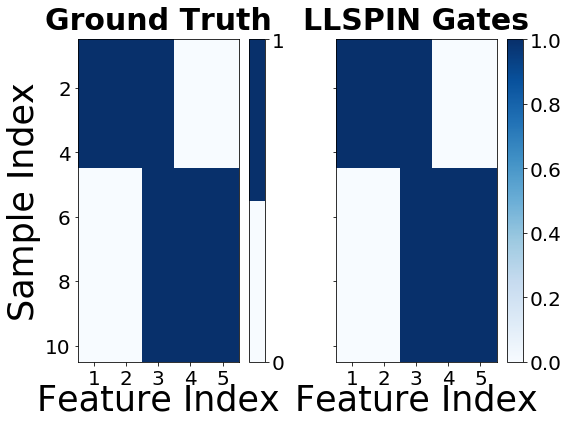

In [69]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

### Comparing the test gates

In [50]:
gate_mat_test = best_model.get_prob_alpha(X_test)

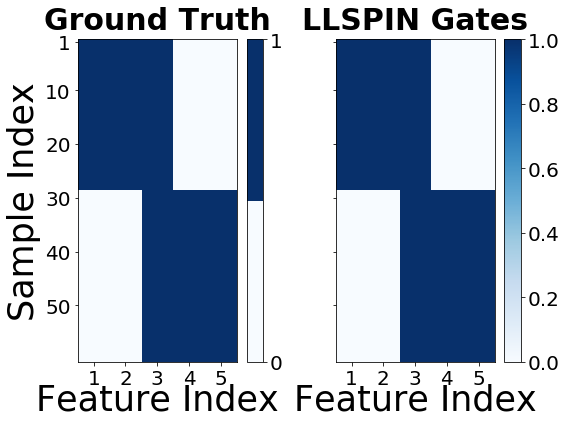

In [70]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

fig.subplots_adjust(bottom=0.01)

im1 = axes[0].imshow(ref_feat_mat_test[sorted_order_test,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([0,9,19,29,39,49])
axes[0].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
im2 = axes[1].imshow(gate_mat_test[sorted_order_test,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([0,9,19,29,39,49])
axes[1].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
    
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()